In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install tensorflow scikit-learn pandas matplotlib seaborn

In [3]:
# YOLOv12 Weapon Detection Implementation
# This script implements weapon detection using YOLOv12 model
# Note: Since YOLOv12 isn't yet widely available, we adapt YOLOv8 with custom configurations

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import shutil
from google.colab import drive, files
from tqdm.notebook import tqdm
import random
import zipfile
from PIL import Image

# Clone the repository containing the dataset
!git clone https://github.com/Mayur241202/Weapon-Detection-V3.git
%cd /content/Weapon-Detection-V3


# Create directories for results
results_dir = '/content/weapon_detection_results/YOLOv12'
os.makedirs(results_dir, exist_ok=True)

Cloning into 'Weapon-Detection-V3'...
remote: Enumerating objects: 2552, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 2552 (delta 1), reused 39 (delta 1), pack-reused 2512 (from 4)
Receiving objects: 100% (2552/2552), 365.36 MiB | 18.27 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Updating files: 100% (3376/3376), done.
/content/Weapon-Detection-V3


In [ ]:
pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 123.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have te

In [3]:
# Improved Weapon Detection Project Implementation with ResNet50

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import zipfile
import shutil

# 1. GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"Found {len(physical_devices)} GPU(s), memory growth enabled")
    except:
        print("Memory growth setting failed, using CPU instead")

# 2. Set random seeds for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 3. Define dataset paths - replace with your paths
RESULTS_ROOT = '/content/weapon_detection_results'
TRAIN_DATA_PATH = '/content/Weapon-Detection-V3/Weapon/Weapon Project/weapon_detection/sorted_images'
VAL_DATA_PATH = '/content/Weapon-Detection-V3/Weapon/Weapon Project/weapon_detection/sorted_images_val'
MODELS_PATH = os.path.join(RESULTS_ROOT, 'models')
REPORTS_PATH = os.path.join(RESULTS_ROOT, 'reports')
PLOTS_PATH = os.path.join(RESULTS_ROOT, 'plots')

# Create necessary directories
os.makedirs(RESULTS_ROOT, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)
os.makedirs(PLOTS_PATH, exist_ok=True)

# 4. Model parameters
IMG_SIZE = 224  # ResNet50 default input size
BATCH_SIZE = 32  # Increased to match ViT implementation
EPOCHS = 30     # Increased epochs for better convergence
LEARNING_RATE = 1e-4  # Reduced to match ViT implementation

def create_class_weights(data_path):
    """Calculate class weights to handle class imbalance using a simpler approach"""
    class_dirs = [os.path.join(data_path, d) for d in os.listdir(data_path)
                 if os.path.isdir(os.path.join(data_path, d))]

    # Get sample counts for each class
    class_counts = {}
    for i, dir_path in enumerate(class_dirs):
        class_counts[i] = len(os.listdir(dir_path))

    # Calculate total samples
    total_samples = sum(class_counts.values())
    n_classes = len(class_counts)

    # Calculate weight as inverse class frequency
    class_weights = {}
    for i, count in class_counts.items():
        class_weights[i] = (1.0 / count) * (total_samples / n_classes)

    return class_weights

def create_model(num_classes):
    """Build and compile improved ResNet50 model for transfer learning"""
    # Load ResNet50 with pre-trained ImageNet weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Only freeze early layers, allow later layers to be fine-tuned from the start
    for layer in base_model.layers[:100]:  # Freeze only first 100 layers
        layer.trainable = False

    # Add custom classification head similar to your ViT approach
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)  # Reduced dropout to prevent underfitting
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Use standard categorical crossentropy like in ViT implementation
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC()]
    )

    return model

def plot_training_curves(history, model_title):
    """Plot and save training curves"""
    plt.figure(figsize=(12, 8))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_title} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_title} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Precision plot
    plt.subplot(2, 2, 3)
    precision_key = next((k for k in history.history if 'precision' in k and not k.startswith('val')), None)
    val_precision_key = next((k for k in history.history if k.startswith('val_precision')), None)
    if precision_key and val_precision_key:
        plt.plot(history.history[precision_key], label='Train')
        plt.plot(history.history[val_precision_key], label='Validation')
        plt.title(f'{model_title} - Precision')
        plt.ylabel('Precision')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')

    # Recall plot
    plt.subplot(2, 2, 4)
    recall_key = next((k for k in history.history if 'recall' in k and not k.startswith('val')), None)
    val_recall_key = next((k for k in history.history if k.startswith('val_recall')), None)
    if recall_key and val_recall_key:
        plt.plot(history.history[recall_key], label='Train')
        plt.plot(history.history[val_recall_key], label='Validation')
        plt.title(f'{model_title} - Recall')
        plt.ylabel('Recall')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, 'training_curves.png'))
    plt.close()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot and save confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, 'confusion_matrix.png'))
    plt.close()

def plot_roc_curve(y_true, y_pred_proba, class_names):
    """Plot ROC curves for multiclass classification"""
    plt.figure(figsize=(10, 8))

    # Compute ROC curve and ROC area for each class
    for i in range(len(class_names)):
        # One-vs-rest ROC curve
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr,
                 label=f'ROC curve (class: {class_names[i]}, area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(PLOTS_PATH, 'roc_curve.png'))
    plt.close()

def train_and_evaluate_model():
    # Get list of classes from training directory
    class_dirs = [os.path.join(TRAIN_DATA_PATH, d) for d in os.listdir(TRAIN_DATA_PATH)
                 if os.path.isdir(os.path.join(TRAIN_DATA_PATH, d))]
    class_names = [os.path.basename(d) for d in class_dirs]
    num_classes = len(class_names)

    print(f"Found {num_classes} classes: {class_names}")

    # Calculate class weights based on training data
    class_weights = create_class_weights(TRAIN_DATA_PATH)
    print("Class weights:", class_weights)

    # Data generators - using more moderate augmentation similar to your ViT transforms
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,            # Reduced from 30
        width_shift_range=0.2,        # Reduced from 0.25
        height_shift_range=0.2,       # Reduced from 0.25
        shear_range=0.2,              # Reduced from 0.25
        zoom_range=0.2,               # Reduced from 0.3
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],  # More moderate brightness variation
        fill_mode='nearest'
    )

    # Simple rescaling for validation data
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Use the same batch size as ViT implementation
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DATA_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,  # Increased to match ViT
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = val_datagen.flow_from_directory(
        VAL_DATA_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    model = create_model(num_classes)
    print(model.summary())

    # Updated callbacks to focus on accuracy and prevent overfitting
    callbacks = [
        ModelCheckpoint(os.path.join(MODELS_PATH, 'best_model.h5'),
                       monitor='val_accuracy',  # Monitor accuracy like in ViT
                       save_best_only=True,
                       mode='max',
                       verbose=1),
        EarlyStopping(monitor='val_accuracy',
                     patience=10,  # Reduced patience
                     restore_best_weights=True,
                     verbose=1),
        ReduceLROnPlateau(monitor='val_loss',  # Monitor loss instead
                         factor=0.5,  # More gradual reduction
                         patience=5,
                         min_lr=1e-6,
                         verbose=1)
    ]

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=callbacks
    )

    plot_training_curves(history, "Weapon Detection ResNet50")

    # Evaluate model on validation set
    validation_generator.reset()
    y_pred_proba = model.predict(validation_generator, verbose=1)
    y_true = validation_generator.classes
    y_pred = np.argmax(y_pred_proba, axis=1)

    class_report = classification_report(y_true, y_pred, target_names=class_names)
    print(class_report)

    with open(os.path.join(REPORTS_PATH, 'classification_report.txt'), 'w') as f:
        f.write(class_report)

    plot_confusion_matrix(y_true, y_pred, class_names)
    plot_roc_curve(y_true, y_pred_proba, class_names)

    model.save(os.path.join(MODELS_PATH, 'final_model.h5'))

    return model, class_names

def fine_tune_model(model, class_names):
    """Optional fine-tuning stage to unfreeze all layers and train at lower learning rate"""
    # Unfreeze all ResNet50 layers
    for layer in model.layers:
        layer.trainable = True

    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE / 10),  # Much lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    fine_tune_callbacks = [
        ModelCheckpoint(os.path.join(MODELS_PATH, 'finetuned_model.h5'),
                       monitor='val_accuracy',
                       save_best_only=True,
                       mode='max',
                       verbose=1),
        EarlyStopping(monitor='val_accuracy',
                     patience=8,
                     restore_best_weights=True,
                     verbose=1),
        ReduceLROnPlateau(monitor='val_loss',
                         factor=0.2,
                         patience=4,
                         min_lr=1e-7,
                         verbose=1)
    ]

    # Create new data generators with less augmentation
    fine_tune_train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,  # Reduced augmentation for fine tuning
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    fine_tune_val_datagen = ImageDataGenerator(rescale=1./255)

    # Load datasets for fine-tuning
    fine_tune_train_generator = fine_tune_train_datagen.flow_from_directory(
        TRAIN_DATA_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE // 2,  # Reduced batch size to prevent OOM errors
        class_mode='categorical',
        shuffle=True
    )

    fine_tune_val_generator = fine_tune_val_datagen.flow_from_directory(
        VAL_DATA_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    print("Fine-tuning all layers of the model with reduced learning rate...")

    # Use calculated class weights
    class_weights = create_class_weights(TRAIN_DATA_PATH)

    fine_tune_history = model.fit(
        fine_tune_train_generator,
        validation_data=fine_tune_val_generator,
        epochs=30,  # Fewer epochs for fine-tuning
        class_weight=class_weights,
        callbacks=fine_tune_callbacks
    )

    # Evaluate final fine-tuned model
    fine_tune_val_generator.reset()
    y_pred_proba = model.predict(fine_tune_val_generator, verbose=1)
    y_true = fine_tune_val_generator.classes
    y_pred = np.argmax(y_pred_proba, axis=1)

    class_report = classification_report(y_true, y_pred, target_names=class_names)
    print("Fine-tuned model performance:")
    print(class_report)

    with open(os.path.join(REPORTS_PATH, 'fine_tuned_classification_report.txt'), 'w') as f:
        f.write(class_report)

    # Save the fine-tuned model
    model.save(os.path.join(MODELS_PATH, 'final_fine_tuned_model.h5'))

    return model

def create_results_zip():
    """Create a zip file of all results"""
    zip_path = '/content/weapon_detection_results.zip'

    # Create a ZIP file of the entire results directory
    shutil.make_archive('/content/weapon_detection_results', 'zip', RESULTS_ROOT)

    print(f"Results have been zipped to {zip_path}")
    print("You can now download the results ZIP file from the Files section in Google Colab.")

def main():
    try:
        # Check if both train and validation directories exist
        if not os.path.exists(TRAIN_DATA_PATH):
            print(f"Error: Training dataset directory not found at {TRAIN_DATA_PATH}")
            return

        if not os.path.exists(VAL_DATA_PATH):
            print(f"Error: Validation dataset directory not found at {VAL_DATA_PATH}")
            return

        # First phase: train with partly frozen model
        model, class_names = train_and_evaluate_model()

        # Ask user if they want to perform fine-tuning
        fine_tune_answer = input("Do you want to perform fine-tuning on all layers? (y/n): ")
        if fine_tune_answer.lower() == 'y':
            model = fine_tune_model(model, class_names)

        # Create downloadable ZIP of results
        create_results_zip()

        print("Training completed successfully.")
        print("Results have been saved and zipped for download.")

    except Exception as e:
        print("An error occurred:", str(e))
        import traceback
        traceback.print_exc()

# Entry point
if __name__ == '__main__':
    main()

Found 1 GPU(s), memory growth enabled
Found 9 classes: ['Shotgun', 'Sword', 'Handgun', 'Grenade Launcher', 'SMG', 'Bazooka', 'Sniper', 'Automatic Rifle', 'Knife']
Class weights: {0: 1.0232974910394266, 1: 0.8935837245696401, 2: 1.132936507936508, 3: 0.9063492063492063, 4: 0.9063492063492063, 5: 1.1748971193415636, 6: 0.8935837245696401, 7: 1.0753295668549905, 8: 1.0938697318007662}
Found 571 images belonging to 9 classes.
Found 143 images belonging to 9 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,215,305 (100.00 MB)

 Trainable params: 22,080,521 (84.23 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

None


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 5/18 ━━━━━━━━━━━━━━━━━━━━ 9s 711ms/step - accuracy: 0.1331 - auc: 0.4897 - loss: 2.3844 - precision: 0.0000e+00 - recall: 0.0000e+00

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1533 - auc: 0.5464 - loss: 2.2749 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.10490, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.1535 - auc: 0.5475 - loss: 2.2726 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1049 - val_auc: 0.5260 - val_loss: 2.2140 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.1740 - auc: 0.6316 - loss: 2.1345 - precision: 0.6224 - recall: 0.0087
Epoch 2: val_accuracy improved from 0.10490 to 0.15385, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1750 - auc: 0.6326 - loss: 2.1329 - precision: 0.6279 - recall: 0.0090 - val_accuracy: 0.1538 - val_auc: 0.5611 - val_loss: 2.1768 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.2035 - auc: 0.6572 - loss: 2.1074 - precision: 0.2897 - recall: 0.0149
Epoch 3: val_accuracy improved from 0.15385 to 0.22378, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2047 - auc: 0.6585 - loss: 2.1044 - precision: 0.2981 - recall: 0.0153 - val_accuracy: 0.2238 - val_auc: 0.6003 - val_loss: 2.1428 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.2683 - auc: 0.7082 - loss: 1.9834 - precision: 0.5192 - recall: 0.0456
Epoch 4: val_accuracy did not improve from 0.22378
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2686 - auc: 0.7087 - loss: 1.9827 - precision: 0.5207 - recall: 0.0458 - val_accuracy: 0.2168 - val_auc: 0.6346 - val_loss: 2.1002 - val_precision: 1.0000 - val_recall: 0.0070 - learning_rate: 1.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.2719 - auc: 0.7231 - loss: 1.9710 - precision: 0.5564 - recall: 0.0576
Epoch 5: val_accuracy did not improve from 0.22378
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2721 - auc: 0.7232 - loss: 1.9705 - precision: 0.

18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3540 - auc: 0.7655 - loss: 1.8302 - precision: 0.6684 - recall: 0.1114 - val_accuracy: 0.2797 - val_auc: 0.7319 - val_loss: 1.9280 - val_precision: 0.6667 - val_recall: 0.0559 - learning_rate: 1.0000e-04
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.3923 - auc: 0.7893 - loss: 1.7687 - precision: 0.6625 - recall: 0.1343
Epoch 8: val_accuracy improved from 0.27972 to 0.32168, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3914 - auc: 0.7888 - loss: 1.7699 - precision: 0.6606 - recall: 0.1336 - val_accuracy: 0.3217 - val_auc: 0.7714 - val_loss: 1.8291 - val_precision: 0.6154 - val_recall: 0.0559 - learning_rate: 1.0000e-04
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.3942 - auc: 0.8091 - loss: 1.6850 - precision: 0.6108 - recall: 0.1413
Epoch 9: val_accuracy did not improve from 0.32168
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3925 - auc: 0.8081 - loss: 1.6892 - precision: 0.6076 - recall: 0.1409 - val_accuracy: 0.2797 - val_auc: 0.7184 - val_loss: 1.9729 - val_precision: 0.6087 - val_recall: 0.0979 - learning_rate: 1.0000e-04
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.4276 - auc: 0.8188 - loss: 1.6505 - precision: 0.6416 - recall: 0.1759
Epoch 10: val_accuracy improved from 0.32168 to 0.38462, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4250 - auc: 0.8176 - loss: 1.6556 - precision: 0.6378 - recall: 0.1739 - val_accuracy: 0.3846 - val_auc: 0.7760 - val_loss: 1.7545 - val_precision: 0.6207 - val_recall: 0.1259 - learning_rate: 1.0000e-04
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.4206 - auc: 0.8224 - loss: 1.6317 - precision: 0.6894 - recall: 0.1894
Epoch 11: val_accuracy did not improve from 0.38462
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4198 - auc: 0.8222 - loss: 1.6331 - precision: 0.6890 - recall: 0.1891 - val_accuracy: 0.3007 - val_auc: 0.7683 - val_loss: 1.8281 - val_precision: 0.5227 - val_recall: 0.1608 - learning_rate: 1.0000e-04
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.4269 - auc: 0.8106 - loss: 1.6754 - precision: 0.5822 - recall: 0.1824
Epoch 12: val_accuracy did not improve from 0.38462
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4263 - auc: 0.8105 - loss: 1.6767 - precision: 0.5832


Epoch 15: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4531 - auc: 0.8544 - loss: 1.4850 - precision: 0.6865 - recall: 0.2820 - val_accuracy: 0.4266 - val_auc: 0.7983 - val_loss: 1.7680 - val_precision: 0.5625 - val_recall: 0.2517 - learning_rate: 1.0000e-04
Epoch 16/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.5349 - auc: 0.8769 - loss: 1.3881 - precision: 0.7636 - recall: 0.3085
Epoch 16: val_accuracy did not improve from 0.42657
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5359 - auc: 0.8774 - loss: 1.3853 - precision: 0.7649 - recall: 0.3101 - val_accuracy: 0.4196 - val_auc: 0.8268 - val_loss: 1.6260 - val_precision: 0.5672 - val_recall: 0.2657 - learning_rate: 5.0000e-05
Epoch 17/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.5393 - auc: 0.8968 - loss: 1.2781 - precision: 0.7706 - recall: 0.3811
Epoch 17: val_accuracy did not improve from 0.42657
18/18 ━━━━━━━━━━━━━━━━━━━━ 1

18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5340 - auc: 0.8793 - loss: 1.3641 - precision: 0.8080 - recall: 0.3644 - val_accuracy: 0.4476 - val_auc: 0.8360 - val_loss: 1.6342 - val_precision: 0.5500 - val_recall: 0.3077 - learning_rate: 5.0000e-05
Epoch 19/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.6229 - auc: 0.9239 - loss: 1.1152 - precision: 0.8301 - recall: 0.4647
Epoch 19: val_accuracy did not improve from 0.44755
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6217 - auc: 0.9232 - loss: 1.1193 - precision: 0.8269 - recall: 0.4625 - val_accuracy: 0.4126 - val_auc: 0.8247 - val_loss: 1.6722 - val_precision: 0.5867 - val_recall: 0.3077 - learning_rate: 5.0000e-05
Epoch 20/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.5802 - auc: 0.9031 - loss: 1.2343 - precision: 0.7524 - recall: 0.4164
Epoch 20: val_accuracy improved from 0.44755 to 0.46853, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5800 - auc: 0.9029 - loss: 1.2357 - precision: 0.7518 - recall: 0.4153 - val_accuracy: 0.4685 - val_auc: 0.8396 - val_loss: 1.6221 - val_precision: 0.5854 - val_recall: 0.3357 - learning_rate: 5.0000e-05
Epoch 21/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.5920 - auc: 0.9009 - loss: 1.2330 - precision: 0.7884 - recall: 0.4082
Epoch 21: val_accuracy improved from 0.46853 to 0.48252, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5927 - auc: 0.9012 - loss: 1.2318 - precision: 0.7883 - recall: 0.4091 - val_accuracy: 0.4825 - val_auc: 0.8605 - val_loss: 1.5450 - val_precision: 0.6145 - val_recall: 0.3566 - learning_rate: 5.0000e-05
Epoch 22/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.6491 - auc: 0.9302 - loss: 1.0473 - precision: 0.8620 - recall: 0.5102
Epoch 22: val_accuracy did not improve from 0.48252
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6473 - auc: 0.9298 - loss: 1.0505 - precision: 0.8592 - recall: 0.5082 - val_accuracy: 0.4545 - val_auc: 0.8508 - val_loss: 1.6264 - val_precision: 0.5647 - val_recall: 0.3357 - learning_rate: 5.0000e-05
Epoch 23/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.5738 - auc: 0.9125 - loss: 1.1867 - precision: 0.7800 - recall: 0.4594
Epoch 23: val_accuracy improved from 0.48252 to 0.52448, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5746 - auc: 0.9127 - loss: 1.1843 - precision: 0.7811 - recall: 0.4597 - val_accuracy: 0.5245 - val_auc: 0.8637 - val_loss: 1.5662 - val_precision: 0.6495 - val_recall: 0.4406 - learning_rate: 5.0000e-05
Epoch 24/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.6403 - auc: 0.9186 - loss: 1.1321 - precision: 0.7990 - recall: 0.4929
Epoch 24: val_accuracy improved from 0.52448 to 0.53147, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6409 - auc: 0.9191 - loss: 1.1287 - precision: 0.7992 - recall: 0.4932 - val_accuracy: 0.5315 - val_auc: 0.8644 - val_loss: 1.4827 - val_precision: 0.6333 - val_recall: 0.3986 - learning_rate: 5.0000e-05
Epoch 25/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.6767 - auc: 0.9445 - loss: 0.9496 - precision: 0.8312 - recall: 0.5566
Epoch 25: val_accuracy improved from 0.53147 to 0.55944, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6758 - auc: 0.9442 - loss: 0.9518 - precision: 0.8300 - recall: 0.5562 - val_accuracy: 0.5594 - val_auc: 0.8785 - val_loss: 1.4398 - val_precision: 0.5982 - val_recall: 0.4685 - learning_rate: 5.0000e-05
Epoch 26/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.6395 - auc: 0.9355 - loss: 1.0142 - precision: 0.7803 - recall: 0.5325
Epoch 26: val_accuracy improved from 0.55944 to 0.57343, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6393 - auc: 0.9355 - loss: 1.0149 - precision: 0.7798 - recall: 0.5324 - val_accuracy: 0.5734 - val_auc: 0.8843 - val_loss: 1.4221 - val_precision: 0.6574 - val_recall: 0.4965 - learning_rate: 5.0000e-05
Epoch 27/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.7258 - auc: 0.9468 - loss: 0.9068 - precision: 0.8314 - recall: 0.6056
Epoch 27: val_accuracy did not improve from 0.57343
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7240 - auc: 0.9465 - loss: 0.9095 - precision: 0.8299 - recall: 0.6051 - val_accuracy: 0.5105 - val_auc: 0.8476 - val_loss: 1.7839 - val_precision: 0.5943 - val_recall: 0.4406 - learning_rate: 5.0000e-05
Epoch 28/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.6753 - auc: 0.9462 - loss: 0.9595 - precision: 0.8165 - recall: 0.5298
Epoch 28: val_accuracy improved from 0.57343 to 0.60140, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6752 - auc: 0.9461 - loss: 0.9598 - precision: 0.8164 - recall: 0.5303 - val_accuracy: 0.6014 - val_auc: 0.8935 - val_loss: 1.3969 - val_precision: 0.6783 - val_recall: 0.5455 - learning_rate: 5.0000e-05
Epoch 29/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.6490 - auc: 0.9340 - loss: 1.0116 - precision: 0.7815 - recall: 0.5586
Epoch 29: val_accuracy improved from 0.60140 to 0.64336, saving model to /content/weapon_detection_results/models/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6506 - auc: 0.9346 - loss: 1.0080 - precision: 0.7834 - recall: 0.5599 - val_accuracy: 0.6434 - val_auc: 0.8925 - val_loss: 1.3410 - val_precision: 0.7069 - val_recall: 0.5734 - learning_rate: 5.0000e-05
Epoch 30/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.6308 - auc: 0.9372 - loss: 1.0171 - precision: 0.7638 - recall: 0.5503
Epoch 30: val_accuracy did not improve from 0.64336
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6331 - auc: 0.9376 - loss: 1.0134 - precision: 0.7646 - recall: 0.5514 - val_accuracy: 0.5874 - val_auc: 0.8857 - val_loss: 1.4056 - val_precision: 0.6852 - val_recall: 0.5175 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 29.
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
                  precision    recall  f1-score   support

         Shotgun       0.58      0.47      0.52        15
           Sword       0.64      0.69      0.67        13
         Handgun       0

Do you want to perform fine-tuning on all layers? (y/n): y
Found 571 images belonging to 9 classes.
Found 143 images belonging to 9 classes.
Fine-tuning all layers of the model with reduced learning rate...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2527 - auc_1: 0.6807 - loss: 2.1545 - precision_1: 0.3553 - recall_1: 0.0715
Epoch 1: val_accuracy improved from -inf to 0.21678, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.2540 - auc_1: 0.6819 - loss: 2.1501 - precision_1: 0.3571 - recall_1: 0.0719 - val_accuracy: 0.2168 - val_auc_1: 0.6302 - val_loss: 3.5006 - val_precision_1: 0.2593 - val_recall_1: 0.1958 - learning_rate: 1.0000e-05
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.4735 - auc_1: 0.8479 - loss: 1.5225 - precision_1: 0.7124 - recall_1: 0.2089
Epoch 2: val_accuracy improved from 0.21678 to 0.26573, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 575ms/step - accuracy: 0.4732 - auc_1: 0.8480 - loss: 1.5222 - precision_1: 0.7128 - recall_1: 0.2095 - val_accuracy: 0.2657 - val_auc_1: 0.6153 - val_loss: 3.0873 - val_precision_1: 0.2584 - val_recall_1: 0.1608 - learning_rate: 1.0000e-05
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.5491 - auc_1: 0.9073 - loss: 1.2521 - precision_1: 0.7929 - recall_1: 0.3236
Epoch 3: val_accuracy did not improve from 0.26573
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 528ms/step - accuracy: 0.5497 - auc_1: 0.9075 - loss: 1.2511 - precision_1: 0.7939 - recall_1: 0.3244 - val_accuracy: 0.2238 - val_auc_1: 0.6157 - val_loss: 2.6285 - val_precision_1: 0.4107 - val_recall_1: 0.1608 - learning_rate: 1.0000e-05
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.6144 - auc_1: 0.9256 - loss: 1.1227 - precision_1: 0.8099 - recall_1: 0.3622
Epoch 4: val_accuracy did not improve from 0.26573
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 537ms/step - accuracy: 0.6154 - auc_1

36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 732ms/step - accuracy: 0.8474 - auc_1: 0.9892 - loss: 0.5175 - precision_1: 0.9235 - recall_1: 0.7480 - val_accuracy: 0.2727 - val_auc_1: 0.6955 - val_loss: 2.0287 - val_precision_1: 0.5000 - val_recall_1: 0.0979 - learning_rate: 1.0000e-05
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8492 - auc_1: 0.9916 - loss: 0.4528 - precision_1: 0.9382 - recall_1: 0.7838
Epoch 9: val_accuracy did not improve from 0.27273
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.8498 - auc_1: 0.9916 - loss: 0.4522 - precision_1: 0.9384 - recall_1: 0.7842 - val_accuracy: 0.2587 - val_auc_1: 0.7239 - val_loss: 1.9704 - val_precision_1: 0.5556 - val_recall_1: 0.1399 - learning_rate: 1.0000e-05
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8891 - auc_1: 0.9894 - loss: 0.4414 - precision_1: 0.9488 - recall_1: 0.7933
Epoch 10: val_accuracy did not improve from 0.27273
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.8893 - auc

36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 665ms/step - accuracy: 0.9313 - auc_1: 0.9959 - loss: 0.3472 - precision_1: 0.9678 - recall_1: 0.8395 - val_accuracy: 0.3147 - val_auc_1: 0.7522 - val_loss: 1.9680 - val_precision_1: 0.5345 - val_recall_1: 0.2168 - learning_rate: 1.0000e-05
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9422 - auc_1: 0.9986 - loss: 0.2426 - precision_1: 0.9656 - recall_1: 0.8919
Epoch 12: val_accuracy did not improve from 0.31469
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.9422 - auc_1: 0.9986 - loss: 0.2430 - precision_1: 0.9657 - recall_1: 0.8921 - val_accuracy: 0.3147 - val_auc_1: 0.7702 - val_loss: 1.9417 - val_precision_1: 0.4861 - val_recall_1: 0.2448 - learning_rate: 1.0000e-05
Epoch 13/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9366 - auc_1: 0.9977 - loss: 0.2540 - precision_1: 0.9644 - recall_1: 0.9008
Epoch 13: val_accuracy improved from 0.31469 to 0.32867, saving model to /content/weapon_detection_results/models/fi

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 586ms/step - accuracy: 0.9368 - auc_1: 0.9977 - loss: 0.2537 - precision_1: 0.9646 - recall_1: 0.9011 - val_accuracy: 0.3287 - val_auc_1: 0.7760 - val_loss: 2.0108 - val_precision_1: 0.4588 - val_recall_1: 0.2727 - learning_rate: 1.0000e-05
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9682 - auc_1: 0.9984 - loss: 0.1935 - precision_1: 0.9746 - recall_1: 0.9328
Epoch 14: val_accuracy improved from 0.32867 to 0.39161, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 561ms/step - accuracy: 0.9683 - auc_1: 0.9984 - loss: 0.1930 - precision_1: 0.9747 - recall_1: 0.9331 - val_accuracy: 0.3916 - val_auc_1: 0.7883 - val_loss: 2.0466 - val_precision_1: 0.4375 - val_recall_1: 0.2937 - learning_rate: 1.0000e-05
Epoch 15/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9497 - auc_1: 0.9990 - loss: 0.1849 - precision_1: 0.9687 - recall_1: 0.9250
Epoch 15: val_accuracy improved from 0.39161 to 0.41259, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 592ms/step - accuracy: 0.9502 - auc_1: 0.9990 - loss: 0.1845 - precision_1: 0.9690 - recall_1: 0.9254 - val_accuracy: 0.4126 - val_auc_1: 0.8012 - val_loss: 2.0897 - val_precision_1: 0.4151 - val_recall_1: 0.3077 - learning_rate: 1.0000e-05
Epoch 16/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9396 - auc_1: 0.9988 - loss: 0.1927 - precision_1: 0.9671 - recall_1: 0.9246
Epoch 16: val_accuracy improved from 0.41259 to 0.44056, saving model to /content/weapon_detection_results/models/finetuned_model.h5



Epoch 16: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 586ms/step - accuracy: 0.9401 - auc_1: 0.9988 - loss: 0.1924 - precision_1: 0.9672 - recall_1: 0.9251 - val_accuracy: 0.4406 - val_auc_1: 0.8202 - val_loss: 2.0526 - val_precision_1: 0.4696 - val_recall_1: 0.3776 - learning_rate: 1.0000e-05
Epoch 17/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9700 - auc_1: 0.9997 - loss: 0.1305 - precision_1: 0.9858 - recall_1: 0.9535
Epoch 17: val_accuracy improved from 0.44056 to 0.45455, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 568ms/step - accuracy: 0.9701 - auc_1: 0.9997 - loss: 0.1307 - precision_1: 0.9858 - recall_1: 0.9536 - val_accuracy: 0.4545 - val_auc_1: 0.8366 - val_loss: 1.9692 - val_precision_1: 0.4876 - val_recall_1: 0.4126 - learning_rate: 2.0000e-06
Epoch 18/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9858 - auc_1: 0.9998 - loss: 0.1125 - precision_1: 0.9951 - recall_1: 0.9665
Epoch 18: val_accuracy improved from 0.45455 to 0.49650, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 616ms/step - accuracy: 0.9855 - auc_1: 0.9998 - loss: 0.1130 - precision_1: 0.9948 - recall_1: 0.9662 - val_accuracy: 0.4965 - val_auc_1: 0.8571 - val_loss: 1.8200 - val_precision_1: 0.5242 - val_recall_1: 0.4545 - learning_rate: 2.0000e-06
Epoch 19/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9861 - auc_1: 0.9995 - loss: 0.1199 - precision_1: 0.9891 - recall_1: 0.9710
Epoch 19: val_accuracy improved from 0.49650 to 0.54545, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 45s 715ms/step - accuracy: 0.9859 - auc_1: 0.9995 - loss: 0.1203 - precision_1: 0.9890 - recall_1: 0.9708 - val_accuracy: 0.5455 - val_auc_1: 0.8820 - val_loss: 1.6378 - val_precision_1: 0.5615 - val_recall_1: 0.5105 - learning_rate: 2.0000e-06
Epoch 20/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9799 - auc_1: 0.9997 - loss: 0.0986 - precision_1: 0.9935 - recall_1: 0.9720
Epoch 20: val_accuracy improved from 0.54545 to 0.55245, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 779ms/step - accuracy: 0.9801 - auc_1: 0.9997 - loss: 0.0991 - precision_1: 0.9935 - recall_1: 0.9719 - val_accuracy: 0.5524 - val_auc_1: 0.9001 - val_loss: 1.4606 - val_precision_1: 0.5906 - val_recall_1: 0.5245 - learning_rate: 2.0000e-06
Epoch 21/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9847 - auc_1: 0.9998 - loss: 0.1044 - precision_1: 0.9900 - recall_1: 0.9800
Epoch 21: val_accuracy improved from 0.55245 to 0.59441, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 640ms/step - accuracy: 0.9847 - auc_1: 0.9998 - loss: 0.1044 - precision_1: 0.9900 - recall_1: 0.9800 - val_accuracy: 0.5944 - val_auc_1: 0.9092 - val_loss: 1.2701 - val_precision_1: 0.6480 - val_recall_1: 0.5664 - learning_rate: 2.0000e-06
Epoch 22/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9923 - auc_1: 1.0000 - loss: 0.0928 - precision_1: 0.9973 - recall_1: 0.9831
Epoch 22: val_accuracy improved from 0.59441 to 0.67832, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 646ms/step - accuracy: 0.9922 - auc_1: 1.0000 - loss: 0.0929 - precision_1: 0.9972 - recall_1: 0.9829 - val_accuracy: 0.6783 - val_auc_1: 0.9200 - val_loss: 1.1153 - val_precision_1: 0.7419 - val_recall_1: 0.6434 - learning_rate: 2.0000e-06
Epoch 23/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9779 - auc_1: 0.9996 - loss: 0.1179 - precision_1: 0.9925 - recall_1: 0.9583
Epoch 23: val_accuracy improved from 0.67832 to 0.70629, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 46s 794ms/step - accuracy: 0.9781 - auc_1: 0.9996 - loss: 0.1176 - precision_1: 0.9925 - recall_1: 0.9586 - val_accuracy: 0.7063 - val_auc_1: 0.9284 - val_loss: 0.9981 - val_precision_1: 0.7857 - val_recall_1: 0.6923 - learning_rate: 2.0000e-06
Epoch 24/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9763 - auc_1: 0.9996 - loss: 0.1126 - precision_1: 0.9846 - recall_1: 0.9565
Epoch 24: val_accuracy improved from 0.70629 to 0.75524, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 637ms/step - accuracy: 0.9763 - auc_1: 0.9996 - loss: 0.1127 - precision_1: 0.9847 - recall_1: 0.9565 - val_accuracy: 0.7552 - val_auc_1: 0.9376 - val_loss: 0.9025 - val_precision_1: 0.8254 - val_recall_1: 0.7273 - learning_rate: 2.0000e-06
Epoch 25/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.9777 - auc_1: 0.9998 - loss: 0.1008 - precision_1: 0.9948 - recall_1: 0.9753
Epoch 25: val_accuracy improved from 0.75524 to 0.77622, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 885ms/step - accuracy: 0.9779 - auc_1: 0.9998 - loss: 0.1008 - precision_1: 0.9947 - recall_1: 0.9754 - val_accuracy: 0.7762 - val_auc_1: 0.9468 - val_loss: 0.8050 - val_precision_1: 0.8385 - val_recall_1: 0.7622 - learning_rate: 2.0000e-06
Epoch 26/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9815 - auc_1: 0.9997 - loss: 0.1160 - precision_1: 0.9859 - recall_1: 0.9628
Epoch 26: val_accuracy improved from 0.77622 to 0.81119, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 601ms/step - accuracy: 0.9815 - auc_1: 0.9997 - loss: 0.1160 - precision_1: 0.9859 - recall_1: 0.9629 - val_accuracy: 0.8112 - val_auc_1: 0.9626 - val_loss: 0.7364 - val_precision_1: 0.8561 - val_recall_1: 0.7902 - learning_rate: 2.0000e-06
Epoch 27/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9832 - auc_1: 0.9998 - loss: 0.1033 - precision_1: 0.9885 - recall_1: 0.9719
Epoch 27: val_accuracy improved from 0.81119 to 0.81818, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 45s 728ms/step - accuracy: 0.9832 - auc_1: 0.9998 - loss: 0.1032 - precision_1: 0.9885 - recall_1: 0.9720 - val_accuracy: 0.8182 - val_auc_1: 0.9677 - val_loss: 0.6614 - val_precision_1: 0.8582 - val_recall_1: 0.8042 - learning_rate: 2.0000e-06
Epoch 28/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9781 - auc_1: 0.9998 - loss: 0.0970 - precision_1: 0.9842 - recall_1: 0.9610
Epoch 28: val_accuracy improved from 0.81818 to 0.82517, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 609ms/step - accuracy: 0.9782 - auc_1: 0.9998 - loss: 0.0968 - precision_1: 0.9843 - recall_1: 0.9613 - val_accuracy: 0.8252 - val_auc_1: 0.9713 - val_loss: 0.6041 - val_precision_1: 0.8722 - val_recall_1: 0.8112 - learning_rate: 2.0000e-06
Epoch 29/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9901 - auc_1: 0.9999 - loss: 0.0771 - precision_1: 0.9951 - recall_1: 0.9826
Epoch 29: val_accuracy improved from 0.82517 to 0.86014, saving model to /content/weapon_detection_results/models/finetuned_model.h5


36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 560ms/step - accuracy: 0.9900 - auc_1: 0.9999 - loss: 0.0776 - precision_1: 0.9950 - recall_1: 0.9824 - val_accuracy: 0.8601 - val_auc_1: 0.9734 - val_loss: 0.5657 - val_precision_1: 0.8872 - val_recall_1: 0.8252 - learning_rate: 2.0000e-06
Epoch 30/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9766 - auc_1: 0.9998 - loss: 0.1034 - precision_1: 0.9905 - recall_1: 0.9700
Epoch 30: val_accuracy did not improve from 0.86014
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 525ms/step - accuracy: 0.9768 - auc_1: 0.9998 - loss: 0.1031 - precision_1: 0.9905 - recall_1: 0.9702 - val_accuracy: 0.8531 - val_auc_1: 0.9741 - val_loss: 0.5386 - val_precision_1: 0.8905 - val_recall_1: 0.8531 - learning_rate: 2.0000e-06
Restoring model weights from the end of the best epoch: 29.
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


Fine-tuned model performance:
                  precision    recall  f1-score   support

         Shotgun       0.77      0.67      0.71        15
           Sword       0.87      1.00      0.93        13
         Handgun       0.80      0.89      0.84        18
Grenade Launcher       0.82      1.00      0.90        14
             SMG       1.00      1.00      1.00        14
         Bazooka       0.78      0.82      0.80        17
          Sniper       0.83      0.62      0.71        16
 Automatic Rifle       0.94      0.83      0.88        18
           Knife       0.94      0.94      0.94        18

        accuracy                           0.86       143
       macro avg       0.86      0.86      0.86       143
    weighted avg       0.86      0.86      0.86       143

Results have been zipped to /content/weapon_detection_results.zip
You can now download the results ZIP file from the Files section in Google Colab.
Training completed successfully.
Results have been saved and zipp

In [4]:
import os
from collections import Counter

data_dir = '/content/Weapon-Detection-V3/Weapon/Weapon Project/weapon_detection/sorted_images_val'
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in os.listdir(data_dir)}
print(class_counts)

{'Shotgun': 16, 'Sword': 18, 'Handgun': 14, 'Grenade Launcher': 18, 'SMG': 17, 'Bazooka': 13, 'Sniper': 18, 'Automatic Rifle': 15, 'Knife': 14}


In [5]:
import os
from collections import Counter

data_dir = '/content/Weapon-Detection-V3/Weapon/Weapon Project/weapon_detection/sorted_images'
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in os.listdir(data_dir)}
print(class_counts)

{'Shotgun': 62, 'Sword': 71, 'Handgun': 56, 'Grenade Launcher': 70, 'SMG': 70, 'Bazooka': 54, 'Sniper': 71, 'Automatic Rifle': 59, 'Knife': 58}


In [6]:
import os
from collections import Counter

data_dir = '/content/Weapon-Detection-V3/Weapon/weapon_detection/cropped/images'
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in os.listdir(data_dir)}
print(class_counts)

{'Shotgun': 118, 'Sword': 130, 'Handgun': 159, 'Grenade Launcher': 104, 'SMG': 145, 'Bazooka': 81, 'Sniper': 115, 'Automatic Rifle': 145, 'Knife': 158}


In [7]:
import os
import zipfile
import shutil
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class ModelComparator:
    def __init__(self, results_root):
        """
        Initialize the ModelComparator with paths aligned with the ResNet training structure.

        Args:
            results_root: Root directory for all results
        """
        # Define paths based on results_root
        self.results_root = results_root
        self.models_path = os.path.join(results_root, 'models')
        self.reports_path = os.path.join(results_root, 'reports')
        self.plots_path = os.path.join(results_root, 'plots')
        self.comparison_path = os.path.join(results_root, 'model_comparison')

        # Set default validation data path - update this based on your dataset structure
        self.images_path = '/content/Weapon-Detection-V3/Weapon/Weapon Project/weapon_detection/sorted_images_val'

        # Create necessary directories
        os.makedirs(self.reports_path, exist_ok=True)
        os.makedirs(self.plots_path, exist_ok=True)
        os.makedirs(self.comparison_path, exist_ok=True)

        # Load models
        self.models = {
            'Best Model': self._load_model('best_model.h5'),
            'Final Model': self._load_model('final_model.h5'),
            'Fine-tuned Model': self._load_model('finetuned_model.h5')
        }

        # Initialize data generator
        self.data_generator = self._prepare_data_generator()

    def _load_model(self, model_filename):
        """Load a model from the models directory."""
        try:
            model_path = os.path.join(self.models_path, model_filename)
            if os.path.exists(model_path):
                print(f"Loading {model_filename}...")
                return load_model(model_path)
            else:
                print(f"Model file {model_filename} not found at {model_path}")
                return None
        except Exception as e:
            print(f"Error loading {model_filename}: {e}")
            return None

    def _prepare_data_generator(self):
        """Prepare data generator for model evaluation."""
        if not os.path.exists(self.images_path):
            print(f"Warning: Validation images path {self.images_path} does not exist.")
            return None

        print(f"Preparing data generator from {self.images_path}")
        datagen = ImageDataGenerator(rescale=1./255)
        return datagen.flow_from_directory(
            self.images_path,
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical',
            shuffle=False
        )

    def evaluate_models(self):
        """Evaluate all models and return performance metrics."""
        if self.data_generator is None:
            print("Cannot evaluate models: data generator not initialized.")
            return {}

        results = {}
        for name, model in self.models.items():
            if model is None:
                print(f"Skipping {name} evaluation: model not loaded.")
                continue

            print(f"Evaluating {name}...")
            self.data_generator.reset()

            y_true = self.data_generator.classes
            class_names = list(self.data_generator.class_indices.keys())

            # Get model predictions
            y_pred_proba = model.predict(self.data_generator)
            y_pred = np.argmax(y_pred_proba, axis=1)

            # Calculate performance metrics
            model_evaluation = model.evaluate(self.data_generator)

            # Store results
            results[name] = {
                'accuracy': model_evaluation[1],
                'classification_report': classification_report(y_true, y_pred, target_names=class_names),
                'confusion_matrix': confusion_matrix(y_true, y_pred),
                'class_indices': self.data_generator.class_indices,
                'y_true': y_true,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }

            # Print immediate results
            print(f"{name} Accuracy: {model_evaluation[1]:.4f}")

        return results

    def plot_confusion_matrices(self, results):
        """Plot confusion matrices for all models."""
        if not results:
            print("No results to plot confusion matrices.")
            return

        plt.figure(figsize=(20, 6))
        for i, model_name in enumerate(results.keys(), 1):
            cm = results[model_name]['confusion_matrix']
            class_names = list(results[model_name]['class_indices'].keys())

            plt.subplot(1, len(results), i)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.title(f'Confusion Matrix - {model_name}')
            plt.xlabel('Predicted')
            plt.ylabel('True')

        plt.tight_layout()
        confusion_matrix_path = os.path.join(self.comparison_path, 'confusion_matrices_comparison.png')
        plt.savefig(confusion_matrix_path)
        plt.close()
        print(f"Confusion matrices saved to {confusion_matrix_path}")

    def plot_roc_curves(self, results):
        """Plot ROC curves for all models and classes."""
        if not results:
            print("No results to plot ROC curves.")
            return

        plt.figure(figsize=(15, 10))

        # Track lines for legend to avoid duplicates
        line_labels = []

        for name, result in results.items():
            y_true = result['y_true']
            y_pred_proba = result['y_pred_proba']
            class_names = list(result['class_indices'].keys())

            for i in range(len(class_names)):
                # One-vs-rest ROC curve
                fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred_proba[:, i])
                roc_auc = auc(fpr, tpr)

                label = f'{name} - {class_names[i]} (AUC = {roc_auc:.2f})'
                plt.plot(fpr, tpr, label=label)
                line_labels.append(label)

        # Add diagonal reference line
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
        plt.legend(loc="lower right")

        roc_curves_path = os.path.join(self.comparison_path, 'roc_curves_comparison.png')
        plt.savefig(roc_curves_path)
        plt.close()
        print(f"ROC curves saved to {roc_curves_path}")

    def plot_accuracy_comparison(self, results):
        """Plot accuracy comparison between models."""
        if not results:
            print("No results to plot accuracy comparison.")
            return

        model_names = list(results.keys())
        accuracies = [results[name]['accuracy'] for name in model_names]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])

        # Add accuracy values on top of bars
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2,
                     bar.get_height() + 0.01,
                     f'{acc:.4f}',
                     ha='center', va='bottom')

        plt.title('Model Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        accuracy_plot_path = os.path.join(self.comparison_path, 'accuracy_comparison.png')
        plt.savefig(accuracy_plot_path)
        plt.close()
        print(f"Accuracy comparison saved to {accuracy_plot_path}")

    def generate_detailed_report(self, results):
        """Generate a detailed text report of model comparisons."""
        if not results:
            print("No results to generate report.")
            return

        report_path = os.path.join(self.comparison_path, 'model_comparison_report.txt')

        with open(report_path, 'w') as f:
            f.write("=== Comprehensive Model Comparison Report ===\n\n")
            f.write(f"Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

            for name, model_results in results.items():
                f.write(f"Model: {name}\n")
                f.write(f"Accuracy: {model_results['accuracy']:.4f}\n")
                f.write("\nClassification Report:\n")
                f.write(model_results['classification_report'])

                # Add confusion matrix summary
                cm = model_results['confusion_matrix']
                f.write("\nConfusion Matrix Summary:\n")
                f.write(f"Total samples: {np.sum(cm)}\n")
                f.write(f"Correctly classified: {np.trace(cm)}\n")
                f.write(f"Misclassified: {np.sum(cm) - np.trace(cm)}\n")

                f.write("\n" + "="*50 + "\n\n")

        print(f"Detailed report saved to {report_path}")

    def zip_results(self):
        """Create a zip file containing all comparison results."""
        # Creating a zip file of the comparison folder
        zip_filename = f"{self.comparison_path}.zip"

        with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, dirs, files in os.walk(self.comparison_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, self.comparison_path)
                    zipf.write(file_path, arcname)

        print(f"Comparison results have been zipped and saved as {zip_filename}")

    def compare_all_models(self):
        """Run the complete model comparison workflow."""
        print("Starting model comparison process...")

        # Evaluate models
        results = self.evaluate_models()

        if not results:
            print("No results generated. Check if models were loaded successfully.")
            return

        # Generate visualizations
        self.plot_confusion_matrices(results)
        self.plot_roc_curves(results)
        self.plot_accuracy_comparison(results)

        # Generate report
        self.generate_detailed_report(results)

        # Zip results
        self.zip_results()

        print("Model comparison completed successfully!")
        return results


def main():
    # Define root path for all results - matching the ResNet50 implementation
    RESULTS_ROOT = '/content/weapon_detection_results'

    # Create model comparator
    print("Initializing ModelComparator...")
    comparator = ModelComparator(RESULTS_ROOT)

    # Run comparison
    comparator.compare_all_models()

    print("Model comparison completed. Check the comparison folder for results.")

if __name__ == '__main__':
    main()

Initializing ModelComparator...
Loading best_model.h5...


Loading final_model.h5...


Loading finetuned_model.h5...


Preparing data generator from /content/Weapon-Detection-V3/Weapon/Weapon Project/weapon_detection/sorted_images_val
Found 143 images belonging to 9 classes.
Starting model comparison process...
Evaluating Best Model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 806ms/step - accuracy: 0.6190 - auc: 0.8689 - loss: 1.4723 - precision: 0.6759 - recall: 0.5401
Best Model Accuracy: 0.6434
Evaluating Final Model...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 807ms/step - accuracy: 0.6190 - auc: 0.8689 - loss: 1.4723 - precision: 0.6759 - recall: 0.5401
Final Model Accuracy: 0.6434
Evaluating Fine-tuned Model...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 976ms/step - accuracy: 0.8670 - auc_1: 0.9724 - loss: 0.5657 - precision_1: 0.9006 - recall_1: 0.8376
Fine-tuned Model Accuracy: 0.8601
Confusion matrices saved to /content/weapon_detection_results/model_comparison/confusion_matrices_comparison.png
ROC curves saved to /content/weapon_detection_results/model_comparison/roc_curves_comparison.png
Accuracy comparison saved to /content/weapon_detection_results/model_comparison/accuracy_comparison.png
Detailed report saved to /content/weapon_detection_results/model_comparison/model_comparison_report.txt
Comparison results have been zipped and saved as /content/weapon_detection_results/model_comparison.zip
Model comparison completed successfully!
Model comparison completed. Check the comparison folder for results.


Confusion Matrix:


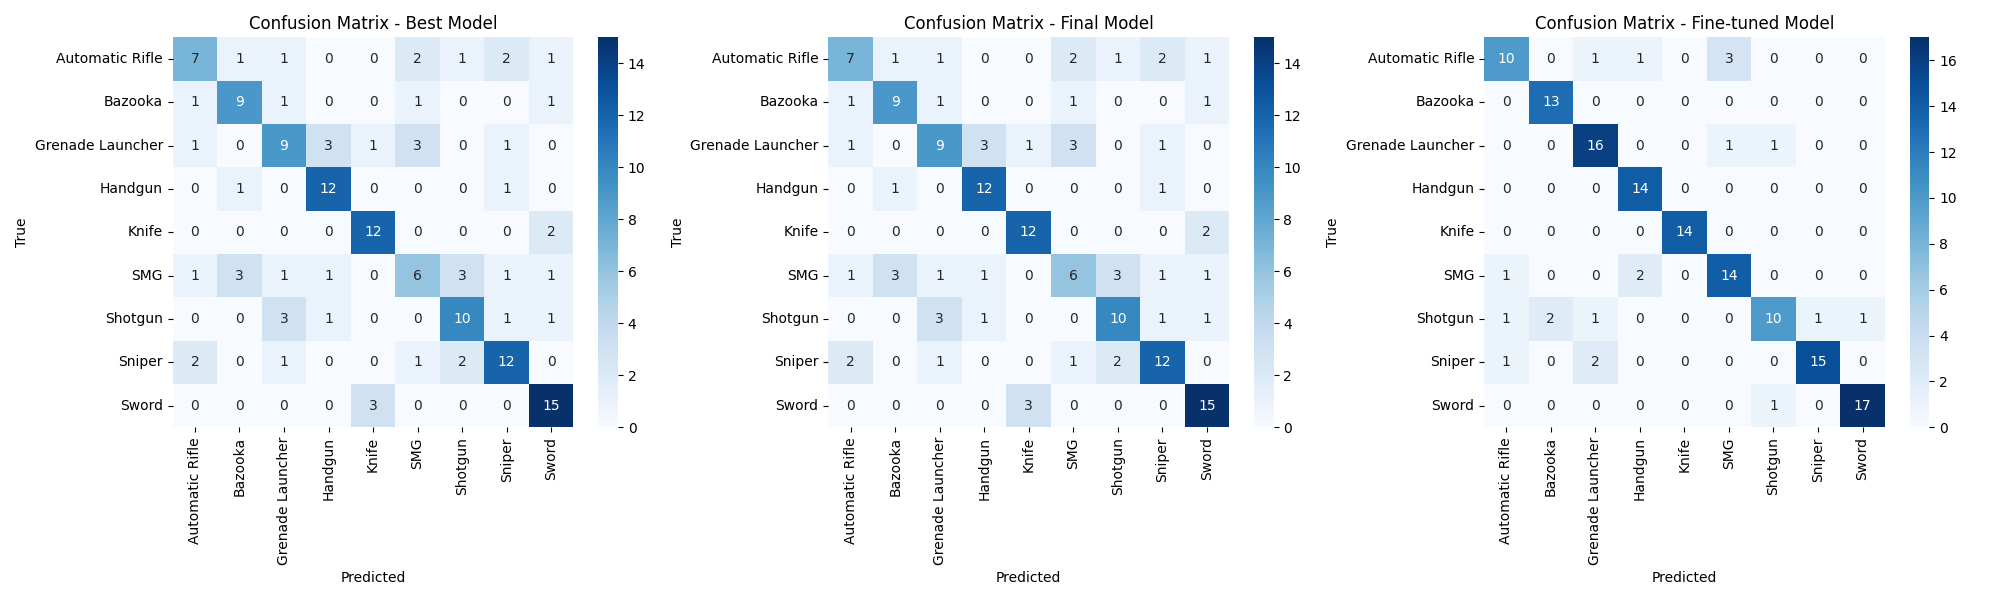


ROC Curves:


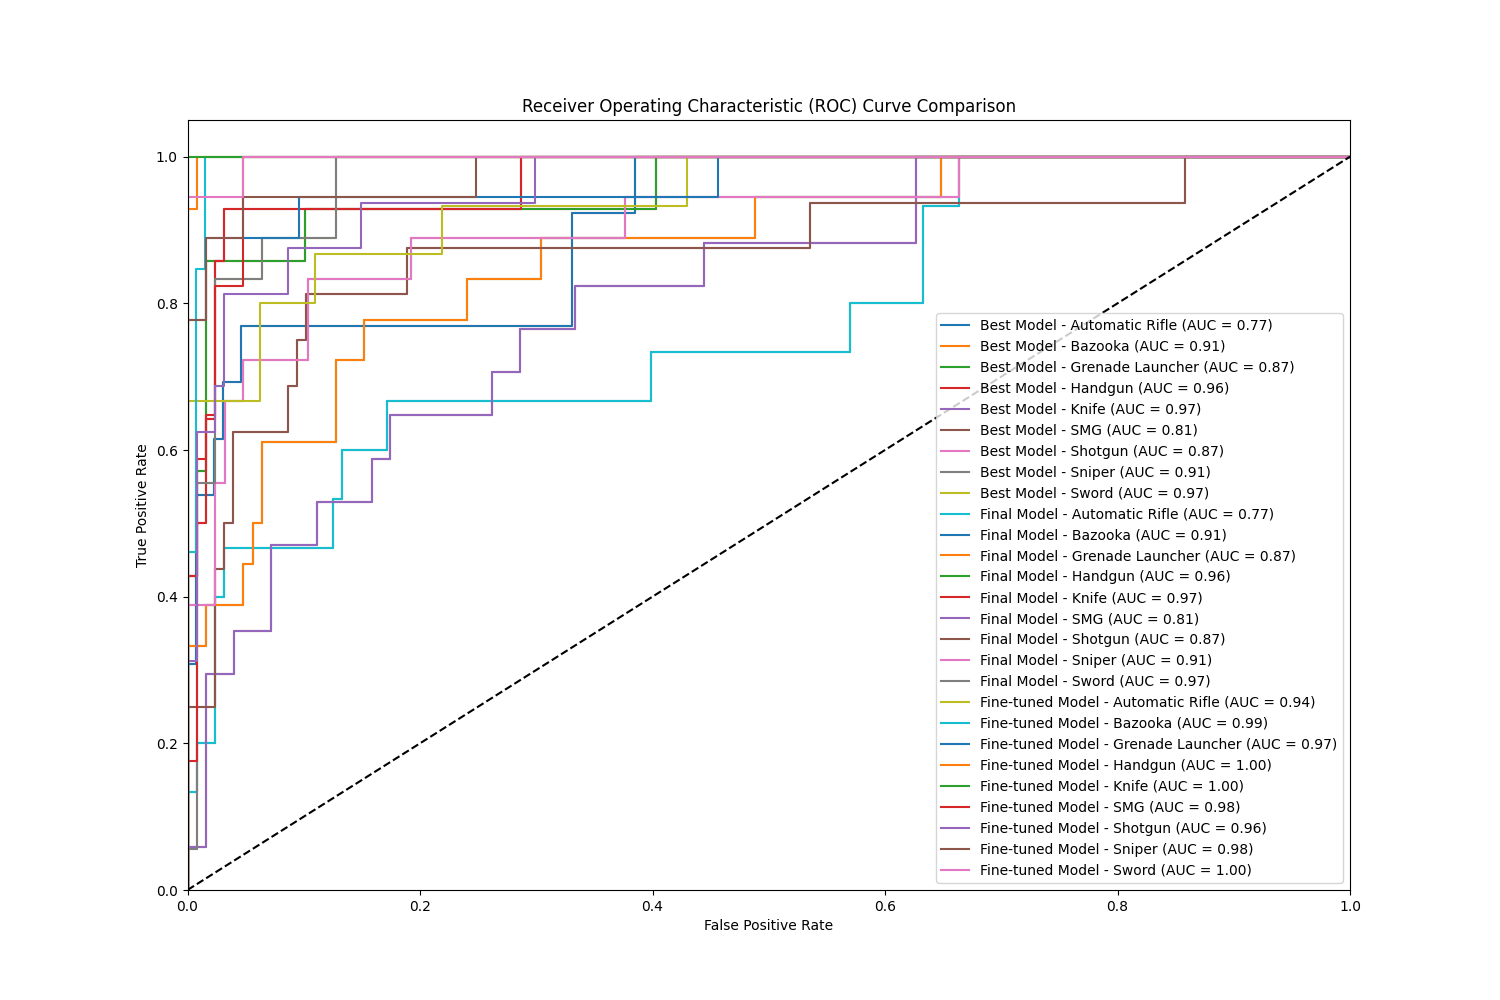


Detailed Report:
=== Comprehensive Model Comparison Report ===

Date: 2025-05-13 13:42:23

Model: Best Model
Accuracy: 0.6434

Classification Report:
                  precision    recall  f1-score   support

 Automatic Rifle       0.58      0.47      0.52        15
         Bazooka       0.64      0.69      0.67        13
Grenade Launcher       0.56      0.50      0.53        18
         Handgun       0.71      0.86      0.77        14
           Knife       0.75      0.86      0.80        14
             SMG       0.46      0.35      0.40        17
         Shotgun       0.62      0.62      0.62        16
          Sniper       0.67      0.67      0.67        18
           Sword       0.71      0.83      0.77        18

        accuracy                           0.64       143
       macro avg       0.63      0.65      0.64       143
    weighted avg       0.63      0.64      0.63       143

Confusion Matrix Summary:
Total samples: 143
Correctly classified: 92
Misclassified: 51


Mo

In [9]:
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display

def view_generated_files():
    # File paths
    confusion_matrix_path = '/content/weapon_detection_results/model_comparison/confusion_matrices_comparison.png'
    roc_curves_path = '/content/weapon_detection_results/model_comparison/roc_curves_comparison.png'
    report_path = '/content/weapon_detection_results/model_comparison/model_comparison_report.txt'

    # Check if the confusion matrix file exists and display it
    if os.path.exists(confusion_matrix_path):
        print("Confusion Matrix:")
        display(Image(filename=confusion_matrix_path))
    else:
        print("Confusion matrix file not found.")

    # Check if the ROC curve file exists and display it
    if os.path.exists(roc_curves_path):
        print("\nROC Curves:")
        display(Image(filename=roc_curves_path))
    else:
        print("ROC curve file not found.")

    # Check if the report file exists and display its contents
    if os.path.exists(report_path):
        print("\nDetailed Report:")
        with open(report_path, 'r') as file:
            report_content = file.read()
            print(report_content)
    else:
        print("Report file not found.")

# Call the function to display files
view_generated_files()

Results extracted to /content/weapon_detection_results_extracted
Classification Report:
                  precision    recall  f1-score   support

         Shotgun       0.77      0.67      0.71        15
           Sword       0.87      1.00      0.93        13
         Handgun       0.80      0.89      0.84        18
Grenade Launcher       0.82      1.00      0.90        14
             SMG       1.00      1.00      1.00        14
         Bazooka       0.78      0.82      0.80        17
          Sniper       0.83      0.62      0.71        16
 Automatic Rifle       0.94      0.83      0.88        18
           Knife       0.94      0.94      0.94        18

        accuracy                           0.86       143
       macro avg       0.86      0.86      0.86       143
    weighted avg       0.86      0.86      0.86       143


Saved Model Files:
- finetuned_model.h5
- best_model.h5
- final_model.h5
- final_fine_tuned_model.h5
Plot fine_tune_curves.png not found


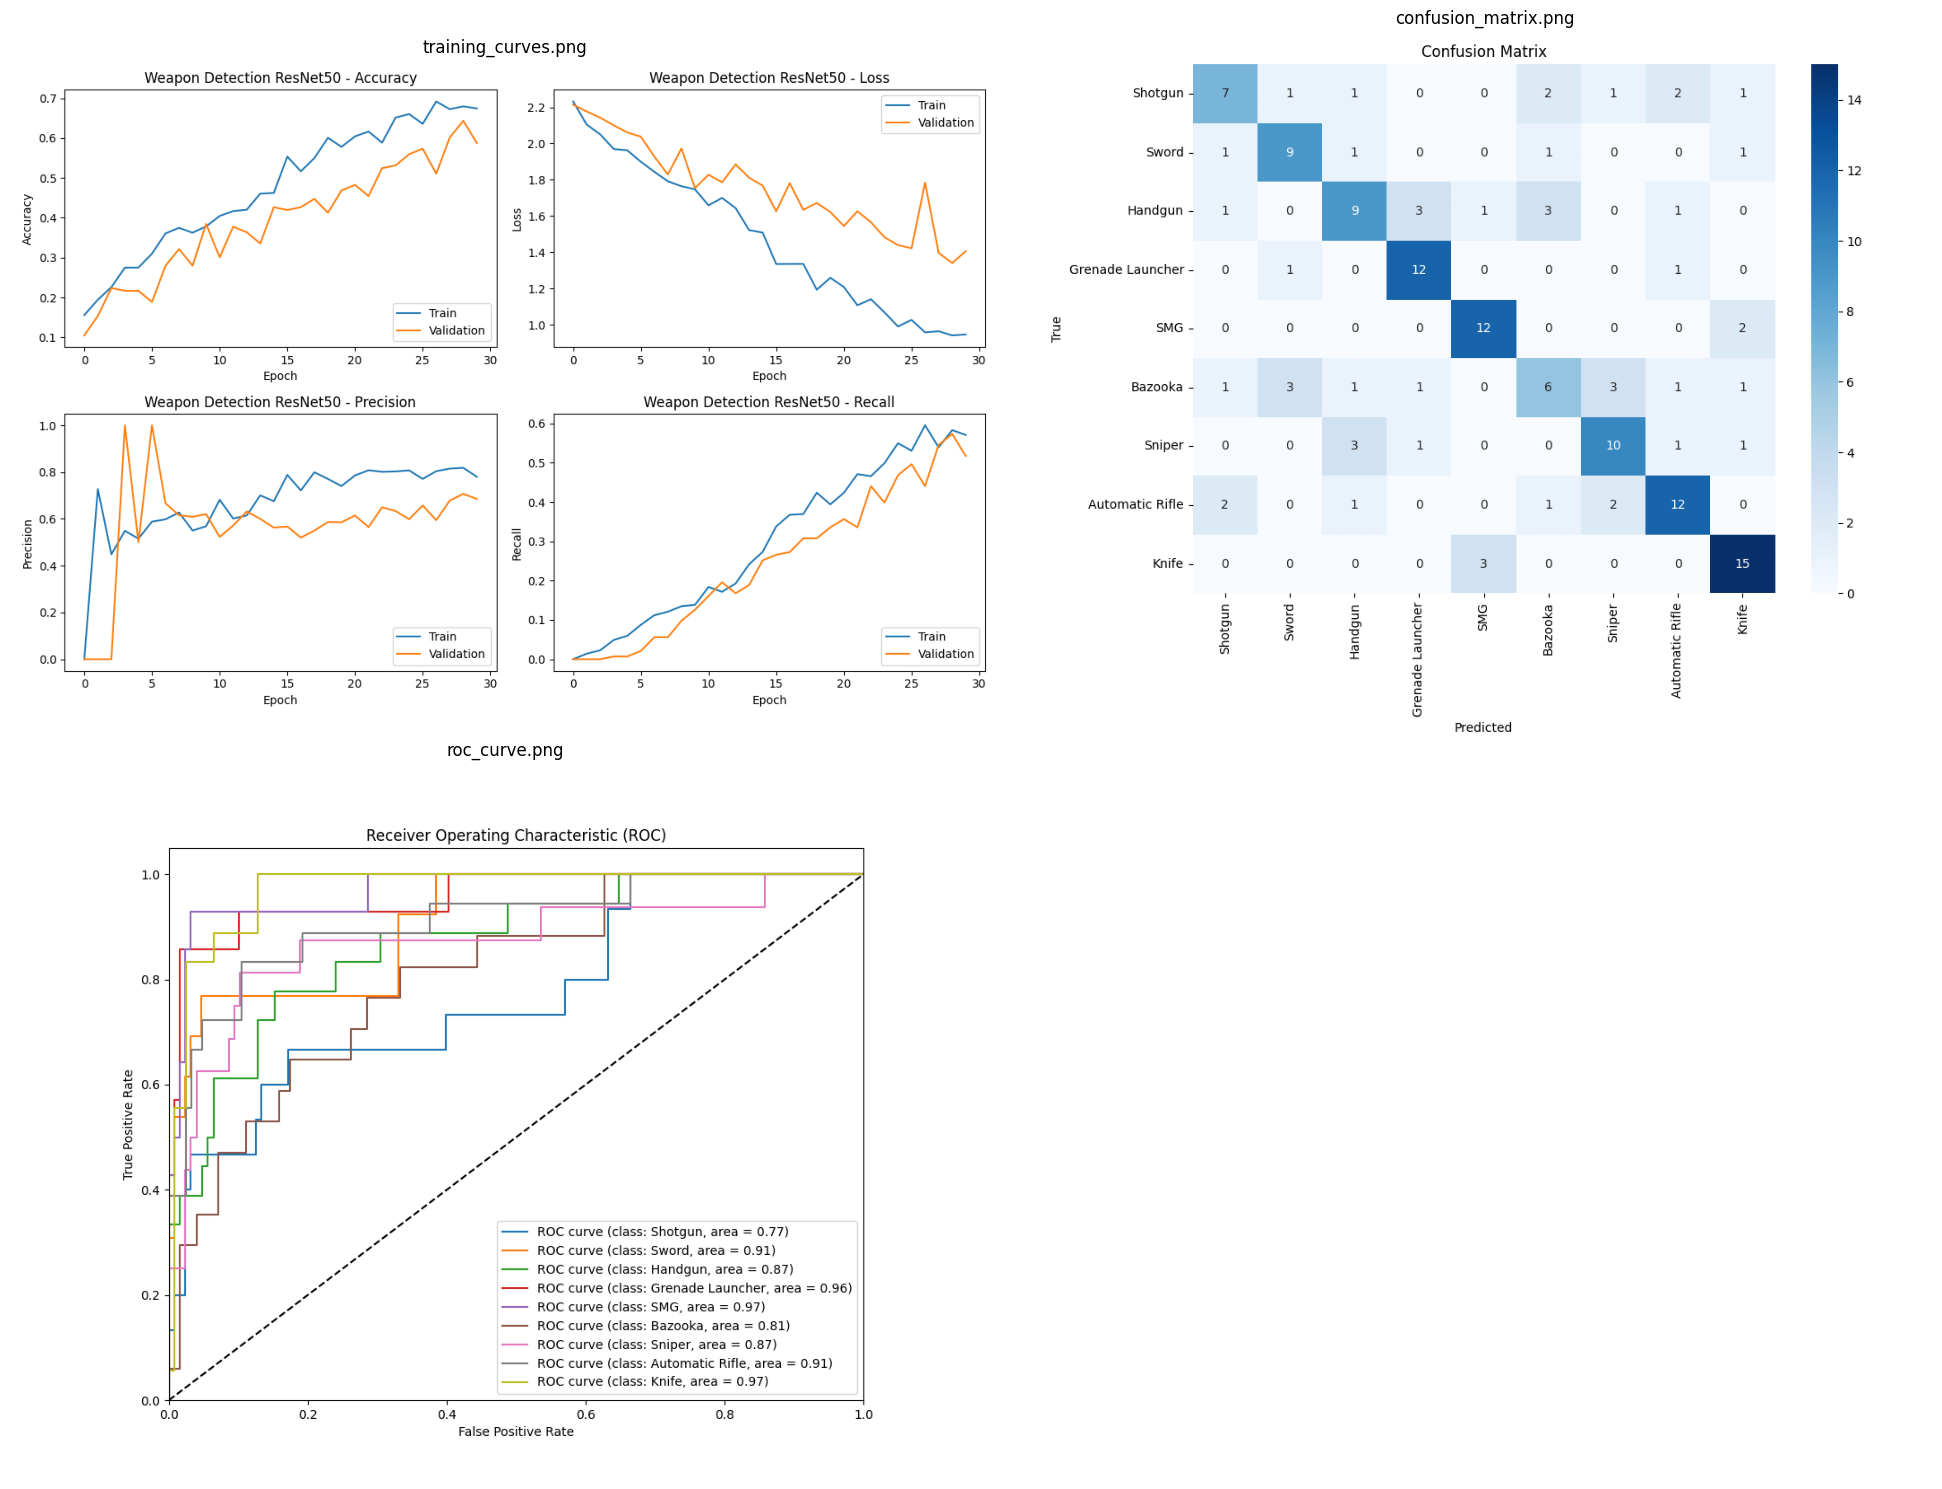

In [10]:
# Weapon Detection Results Viewer

import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

def extract_results(zip_path='/content/weapon_detection_results.zip',
                    extract_path='/content/weapon_detection_results_extracted'):
    """
    Extract the results ZIP file to a specified directory

    Args:
        zip_path (str): Path to the ZIP file
        extract_path (str): Directory to extract results to

    Returns:
        str: Path to the extracted results directory
    """
    # Create extraction directory if it doesn't exist
    os.makedirs(extract_path, exist_ok=True)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print(f"Results extracted to {extract_path}")
    return extract_path

def view_classification_report(results_path):
    """
    Read and print the classification report

    Args:
        results_path (str): Path to the extracted results directory
    """
    report_path = os.path.join(results_path, 'reports', 'fine_tuned_classification_report.txt')

    try:
        with open(report_path, 'r') as f:
            print("Classification Report:")
            print(f.read())
    except FileNotFoundError:
        print(f"Classification report not found at {report_path}")

def display_plots(results_path):
    """
    Display all saved plots

    Args:
        results_path (str): Path to the extracted results directory
    """
    plots_dir = os.path.join(results_path, 'plots')
    plot_files = [
        'training_curves.png',
        'confusion_matrix.png',
        'roc_curve.png',
        'fine_tune_curves.png'
    ]

    # Create a figure to display all plots
    plt.figure(figsize=(20, 15))

    for i, plot_file in enumerate(plot_files, 1):
        plot_path = os.path.join(plots_dir, plot_file)

        if os.path.exists(plot_path):
            # Add a subplot for each plot
            plt.subplot(2, 2, i)
            img = plt.imread(plot_path)
            plt.imshow(img)
            plt.title(plot_file)
            plt.axis('off')
        else:
            print(f"Plot {plot_file} not found")

    plt.tight_layout()
    plt.show()

def list_saved_models(results_path):
    """
    List all saved model files

    Args:
        results_path (str): Path to the extracted results directory
    """
    models_dir = os.path.join(results_path, 'models')

    print("\nSaved Model Files:")
    for model_file in os.listdir(models_dir):
        if model_file.endswith('.h5'):
            print(f"- {model_file}")

def main():
    try:
        # Extract results
        results_path = extract_results()

        # View classification report
        view_classification_report(results_path)

        # List saved models
        list_saved_models(results_path)

        # Display plots
        display_plots(results_path)

    except Exception as e:
        print("An error occurred:", str(e))
        import traceback
        traceback.print_exc()

# Entry point
if __name__ == '__main__':
    main()

In [8]:
from google.colab import files

# Path to your ZIP file
zip_path = '/content/weapon_detection_results.zip'

# Download the file
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Weapon Detection ResNet50 Inference Code
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import glob
from PIL import Image
import time

# Configuration
IMG_SIZE = 224  # ResNet50 default input size
MODEL_PATH = 'path/to/your/model/final_model.h5'  # Change to your model path
TEST_IMAGES_PATH = 'path/to/test/images'  # Change to your test images folder
RESULTS_PATH = 'inference_results'  # Where to save inference results

# Create results directory
os.makedirs(RESULTS_PATH, exist_ok=True)

def load_and_preprocess_image(img_path):
    """Load and preprocess a single image"""
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # ResNet50 preprocessing
    return img, img_array

def predict_image(model, img_path, class_names):
    """Make prediction on single image and return results"""
    start_time = time.time()

    # Load and preprocess image
    original_img, processed_img = load_and_preprocess_image(img_path)

    # Make prediction
    predictions = model.predict(processed_img)
    top_pred_idx = np.argmax(predictions[0])
    top_pred_score = float(predictions[0][top_pred_idx])
    predicted_class = class_names[top_pred_idx]

    # Calculate inference time
    inference_time = time.time() - start_time

    return {
        'image_path': img_path,
        'predicted_class': predicted_class,
        'confidence': top_pred_score,
        'predictions': predictions[0],
        'inference_time': inference_time,
        'original_img': original_img
    }

def visualize_prediction(result, class_names, save_path=None):
    """Visualize prediction results"""
    img = result['original_img']
    predictions = result['predictions']

    # Create figure
    plt.figure(figsize=(12, 6))

    # Plot image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Prediction: {result['predicted_class']}\nConfidence: {result['confidence']:.2%}")
    plt.axis('off')

    # Plot probability distribution
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(class_names))
    plt.barh(y_pos, predictions)
    plt.yticks(y_pos, class_names)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')
    plt.tight_layout()

    # Save or show
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def batch_predict(model, images_path, class_names, batch_size=16):
    """Process multiple images in batch for efficiency"""
    # Get all image files
    image_files = []
    for ext in ['jpg', 'jpeg', 'png']:
        image_files.extend(glob.glob(os.path.join(images_path, f'*.{ext}')))
        image_files.extend(glob.glob(os.path.join(images_path, f'*.{ext.upper()}')))

    if not image_files:
        print(f"No images found in {images_path}")
        return []

    print(f"Found {len(image_files)} images to process")

    results = []
    for i, img_path in enumerate(image_files):
        try:
            print(f"Processing image {i+1}/{len(image_files)}: {os.path.basename(img_path)}")
            result = predict_image(model, img_path, class_names)

            # Save visualization
            save_path = os.path.join(RESULTS_PATH, f"{os.path.splitext(os.path.basename(img_path))[0]}_result.png")
            visualize_prediction(result, class_names, save_path)

            results.append(result)

        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

    return results

def generate_report(results, output_path):
    """Generate a summary report of predictions"""
    report_path = os.path.join(output_path, 'inference_report.txt')

    with open(report_path, 'w') as f:
        f.write("======= Weapon Detection Inference Report =======\n\n")
        f.write(f"Total images processed: {len(results)}\n")
        f.write("\nDetailed Results:\n")

        for i, result in enumerate(results):
            f.write(f"\n--- Image {i+1}: {os.path.basename(result['image_path'])} ---\n")
            f.write(f"Predicted class: {result['predicted_class']}\n")
            f.write(f"Confidence: {result['confidence']:.2%}\n")
            f.write(f"Inference time: {result['inference_time']:.4f} seconds\n")

    print(f"Report generated at {report_path}")

def main():
    try:
        # Check if model path exists
        if not os.path.exists(MODEL_PATH):
            print(f"Error: Model file not found at {MODEL_PATH}")
            return

        # Load model
        print("Loading trained model...")
        model = load_model(MODEL_PATH)
        print("Model loaded successfully!")

        # Define class names - update these to match your trained classes
        # You can either hardcode these based on your training data or load them from a file
        class_names = ["gun", "knife", "no_weapon"]  # Replace with your actual class names

        # Process all test images
        results = batch_predict(model, TEST_IMAGES_PATH, class_names)

        if results:
            # Generate summary report
            generate_report(results, RESULTS_PATH)

            # Print sample results
            print("\nSample predictions:")
            for i, result in enumerate(results[:5]):  # Show first 5 results
                print(f"Image: {os.path.basename(result['image_path'])}")
                print(f"Prediction: {result['predicted_class']} with {result['confidence']:.2%} confidence")
                print(f"Inference time: {result['inference_time']:.4f} seconds\n")

            print(f"All results saved to {RESULTS_PATH}")

    except Exception as e:
        print("An error occurred:", str(e))
        import traceback
        traceback.print_exc()

# Function to perform inference on a single image (useful for external calls)
def predict_single_image(image_path, model_path=MODEL_PATH):
    """Utility function to predict a single image from external code"""
    # Load model
    model = load_model(model_path)

    # Define class names - update these to match your trained classes
    class_names = ["gun", "knife", "no_weapon"]  # Replace with your actual class names

    # Process image
    result = predict_image(model, image_path, class_names)

    return {
        'image_path': image_path,
        'predicted_class': result['predicted_class'],
        'confidence': result['confidence'],
        'class_probabilities': dict(zip(class_names, result['predictions'].tolist()))
    }

# Entry point
if __name__ == '__main__':
    main()

In [6]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model
        self.target_layer = target_layer
        self.device = device
        self.model.to(self.device)
        self.model.eval()
        self.gradients = None
        self.activations = None
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def _preprocess_image(self, img_path, resize=None):
        if isinstance(img_path, str):
            img = Image.open(img_path).convert('RGB')
        else:
            img = img_path
        if resize:
            img = img.resize(resize)
        img_tensor = torch.FloatTensor(np.array(img)).permute(2, 0, 1).unsqueeze(0)
        img_tensor = img_tensor / 255.0
        return img_tensor.to(self.device)

    def _get_cam(self, class_idx=None):
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]
        cam = np.maximum(cam, 0)
        if np.max(cam) > 0:
            cam = cam / np.max(cam)
        return cam

    def _create_heatmap(self, cam, img, alpha=0.5):
        if isinstance(img, str):
            orig_img = cv2.imread(img)
        else:
            orig_img = np.array(img)
            if len(orig_img.shape) == 3 and orig_img.shape[2] == 3:
                orig_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)
        h, w = orig_img.shape[:2]
        cam_resized = cv2.resize(cam, (w, h))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        result = heatmap * alpha + orig_img * (1 - alpha)
        result = result / np.max(result) * 255
        return np.uint8(result)

class ResNetGradCAM(GradCAM):
    def generate_cam(self, img_path, class_idx=None, resize=(224, 224)):
        img_tensor = self._preprocess_image(img_path, resize)
        output = self.model(img_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        cam = self._get_cam(class_idx)
        if isinstance(img_path, str):
            orig_img = Image.open(img_path).convert('RGB')
        else:
            orig_img = img_path
        heatmap_img = self._create_heatmap(cam, orig_img)
        return heatmap_img, cam, class_idx

class YOLOGradCAM(GradCAM):
    def generate_cam(self, img_path, target_box=None, target_class=None, resize=(640, 640)):
        img_tensor = self._preprocess_image(img_path, resize)
        self.model.zero_grad()
        detections = self.model(img_tensor)
        if hasattr(detections, 'pred'):
            pred = detections.pred[0]
        else:
            pred = detections[0] if isinstance(detections, list) else detections
        if target_box is None and target_class is None:
            best_detection_idx = torch.argmax(pred[:, 4]).item()
            target_box = pred[best_detection_idx, :4]
            target_class = int(pred[best_detection_idx, 5].item())
        if target_box is not None:
            ious = bbox_iou(target_box.unsqueeze(0), pred[:, :4])
            best_match_idx = torch.argmax(ious).item()
            loss = pred[best_match_idx, 4]
        else:
            class_mask = pred[:, 5] == target_class
            if torch.any(class_mask):
                best_class_det_idx = torch.argmax(pred[class_mask, 4]).item()
                class_indices = torch.where(class_mask)[0]
                loss = pred[class_indices[best_class_det_idx], 4]
            else:
                best_detection_idx = torch.argmax(pred[:, 4]).item()
                loss = pred[best_detection_idx, 4]
        loss.backward(retain_graph=True)
        cam = self._get_cam()
        if isinstance(img_path, str):
            orig_img = Image.open(img_path).convert('RGB')
        else:
            orig_img = img_path
        heatmap_img = self._create_heatmap(cam, orig_img)
        return heatmap_img, cam, pred.detach().cpu().numpy()

def bbox_iou(box1, box2):
    x1 = torch.max(box1[:, 0], box2[:, 0])
    y1 = torch.max(box1[:, 1], box2[:, 1])
    x2 = torch.min(box1[:, 2], box2[:, 2])
    y2 = torch.min(box1[:, 3], box2[:, 3])
    width = torch.clamp(x2 - x1, min=0)
    height = torch.clamp(y2 - y1, min=0)
    intersection = width * height
    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union = box1_area + box2_area - intersection
    iou = intersection / (union + 1e-6)
    return iou

def visualize_gradcam(original_img, heatmap_img, cam_raw, title="GradCAM Visualization"):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    if isinstance(original_img, str):
        original = Image.open(original_img).convert('RGB')
        plt.imshow(original)
    else:
        plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(cam_raw, cmap='jet')
    plt.title("GradCAM Activation Map")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(heatmap_img)
    plt.title("GradCAM Heatmap Overlay")
    plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def compare_gradcam_models(image_path, yolo_model, resnet_model, yolo_target_layer, resnet_target_layer):
    yolo_gradcam = YOLOGradCAM(yolo_model, yolo_target_layer)
    resnet_gradcam = ResNetGradCAM(resnet_model, resnet_target_layer)
    yolo_heatmap, yolo_cam, yolo_detections = yolo_gradcam.generate_cam(image_path)
    resnet_heatmap, resnet_cam, pred_class = resnet_gradcam.generate_cam(image_path)
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 3, 1)
    orig_img = Image.open(image_path).convert('RGB') if isinstance(image_path, str) else image_path
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(2, 3, 2)
    plt.imshow(yolo_cam, cmap='jet')
    plt.title("YOLOv12 GradCAM Map")
    plt.axis('off')
    plt.subplot(2, 3, 3)
    plt.imshow(yolo_heatmap)
    plt.title("YOLOv12 GradCAM Overlay")
    plt.axis('off')
    plt.subplot(2, 3, 5)
    plt.imshow(resnet_cam, cmap='jet')
    plt.title("ResNet50 GradCAM Map")
    plt.axis('off')
    plt.subplot(2, 3, 6)
    plt.imshow(resnet_heatmap)
    plt.title("ResNet50 GradCAM Overlay")
    plt.axis('off')
    plt.suptitle("Comparing GradCAM: YOLOv12 (Detection) vs ResNet50 (Classification)")
    plt.tight_layout()
    plt.show()
    return {
        'yolo': {
            'heatmap': yolo_heatmap,
            'cam': yolo_cam,
            'detections': yolo_detections
        },
        'resnet': {
            'heatmap': resnet_heatmap,
            'cam': resnet_cam,
            'class': pred_class
        }
    }


In [16]:
# Save GradCAM implementation as a Python module
%%writefile gradcam_implementation.py
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

class GradCAM:
    """
    Generic GradCAM implementation that works for both classification and detection models
    """
    def __init__(self, model, target_layer, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model
        self.target_layer = target_layer
        self.device = device
        self.model.to(self.device)
        self.model.eval()

        # Save gradients and activations
        self.gradients = None
        self.activations = None

        # Register hooks
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # Register the hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def _preprocess_image(self, img_path, resize=None):
        """Preprocess image for model input"""
        if isinstance(img_path, str):
            img = Image.open(img_path).convert('RGB')
        else:
            img = img_path

        if resize:
            img = img.resize(resize)

        img_tensor = torch.FloatTensor(np.array(img)).permute(2, 0, 1).unsqueeze(0)
        img_tensor = img_tensor / 255.0  # Normalize to [0,1]
        return img_tensor.to(self.device)

    def _get_cam(self, class_idx=None):
        """Generate the CAM for the specified class"""
        # Get gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Compute weights based on global average pooling of gradients
        weights = np.mean(gradients, axis=(1, 2))

        # Create weighted combination of activation maps
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        # Apply ReLU to focus on positive influence
        cam = np.maximum(cam, 0)

        # Normalize the CAM to [0, 1]
        if np.max(cam) > 0:
            cam = cam / np.max(cam)

        return cam

    def _create_heatmap(self, cam, img, alpha=0.5):
        """Create heatmap overlay on the original image"""
        # Resize CAM to match image size
        if isinstance(img, str):
            orig_img = cv2.imread(img)
        else:
            orig_img = np.array(img)
            if len(orig_img.shape) == 3 and orig_img.shape[2] == 3:
                orig_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)

        h, w = orig_img.shape[:2]
        cam_resized = cv2.resize(cam, (w, h))

        # Convert CAM to heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay heatmap on original image
        result = heatmap * alpha + orig_img * (1 - alpha)
        result = result / np.max(result) * 255
        return np.uint8(result)


class ResNetGradCAM(GradCAM):
    """
    GradCAM implementation specifically for ResNet50 classification model
    """
    def generate_cam(self, img_path, class_idx=None, resize=(224, 224)):
        """Generate CAM for a classification prediction"""
        img_tensor = self._preprocess_image(img_path, resize)

        # Forward pass
        output = self.model(img_tensor)

        # If class_idx is None, use the predicted class
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1

        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)

        # Generate CAM
        cam = self._get_cam(class_idx)

        # Get original image
        if isinstance(img_path, str):
            orig_img = Image.open(img_path).convert('RGB')
        else:
            orig_img = img_path

        # Create heatmap
        heatmap_img = self._create_heatmap(cam, orig_img)

        return heatmap_img, cam, class_idx


class YOLOGradCAM(GradCAM):
    """
    GradCAM implementation specifically for YOLOv12 detection model
    """
    def generate_cam(self, img_path, target_box=None, target_class=None, resize=(640, 640)):
        """
        Generate CAM for an object detection prediction

        Parameters:
        - img_path: Path to image or PIL Image
        - target_box: Specific bounding box to focus on [x1, y1, x2, y2]
        - target_class: Target class ID to focus on
        - resize: Input size for the model

        Returns:
        - heatmap_img: Original image with heatmap overlay
        - cam: Raw CAM (activation map)
        - detections: Detection results
        """
        img_tensor = self._preprocess_image(img_path, resize)

        # For YOLOv12 we need to handle the output differently
        # Forward pass (detection mode)
        self.model.zero_grad()
        detections = self.model(img_tensor)

        # Get detected boxes
        # Note: Actual format depends on your YOLOv12 implementation
        # This is a simplified example
        if hasattr(detections, 'pred'):
            pred = detections.pred[0]
        else:
            # Assuming detections is already the prediction tensor
            pred = detections[0] if isinstance(detections, list) else detections

        # If no target specified, use the highest confidence detection
        if target_box is None and target_class is None:
            # Assuming pred format is [x1, y1, x2, y2, conf, class_id]
            best_detection_idx = torch.argmax(pred[:, 4]).item()
            target_box = pred[best_detection_idx, :4]
            target_class = int(pred[best_detection_idx, 5].item())

        # Create a pseudo loss for the selected detection
        # We'll use the confidence score or objectness score as the target for backprop
        if target_box is not None:
            # Find the detection that best matches the target_box
            ious = bbox_iou(target_box.unsqueeze(0), pred[:, :4])
            best_match_idx = torch.argmax(ious).item()
            loss = pred[best_match_idx, 4]  # Use confidence score
        else:
            # Filter by class
            class_mask = pred[:, 5] == target_class
            if torch.any(class_mask):
                best_class_det_idx = torch.argmax(pred[class_mask, 4]).item()
                class_indices = torch.where(class_mask)[0]
                loss = pred[class_indices[best_class_det_idx], 4]
            else:
                # If no matching class, use the highest confidence detection
                best_detection_idx = torch.argmax(pred[:, 4]).item()
                loss = pred[best_detection_idx, 4]

        # Backward pass
        loss.backward(retain_graph=True)

        # Generate CAM
        cam = self._get_cam()

        # Get original image
        if isinstance(img_path, str):
            orig_img = Image.open(img_path).convert('RGB')
        else:
            orig_img = img_path

        # Create heatmap
        heatmap_img = self._create_heatmap(cam, orig_img)

        return heatmap_img, cam, pred.detach().cpu().numpy()


def bbox_iou(box1, box2):
    """
    Calculate IoU between bounding boxes
    box format: [x1, y1, x2, y2]
    """
    # Get coordinates of intersection
    x1 = torch.max(box1[:, 0], box2[:, 0])
    y1 = torch.max(box1[:, 1], box2[:, 1])
    x2 = torch.min(box1[:, 2], box2[:, 2])
    y2 = torch.min(box1[:, 3], box2[:, 3])

    # Calculate area of intersection and union
    width = torch.clamp(x2 - x1, min=0)
    height = torch.clamp(y2 - y1, min=0)
    intersection = width * height

    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union = box1_area + box2_area - intersection

    iou = intersection / (union + 1e-6)
    return iou


def visualize_gradcam(original_img, heatmap_img, cam_raw, title="GradCAM Visualization"):
    """
    Visualize the original image and the GradCAM heatmap
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    if isinstance(original_img, str):
        original = Image.open(original_img).convert('RGB')
        plt.imshow(original)
    else:
        plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cam_raw, cmap='jet')
    plt.title("GradCAM Activation Map")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(heatmap_img)
    plt.title("GradCAM Heatmap Overlay")
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Function to apply GradCAM on both models for comparison
def compare_gradcam_models(image_path, yolo_model, resnet_model, yolo_target_layer, resnet_target_layer):
    """
    Apply GradCAM on both YOLOv12 and ResNet50 models and visualize the results
    """
    # Initialize GradCAM for both models
    yolo_gradcam = YOLOGradCAM(yolo_model, yolo_target_layer)
    resnet_gradcam = ResNetGradCAM(resnet_model, resnet_target_layer)

    # Generate GradCAM for YOLOv12
    yolo_heatmap, yolo_cam, yolo_detections = yolo_gradcam.generate_cam(image_path)

    # Generate GradCAM for ResNet50
    resnet_heatmap, resnet_cam, pred_class = resnet_gradcam.generate_cam(image_path)

    # Visualize GradCAM for YOLOv12
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 3, 1)
    orig_img = Image.open(image_path).convert('RGB') if isinstance(image_path, str) else image_path
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(yolo_cam, cmap='jet')
    plt.title("YOLOv12 GradCAM Map")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(yolo_heatmap)
    plt.title("YOLOv12 GradCAM Overlay")
    plt.axis('off')

    # Visualize GradCAM for ResNet50
    plt.subplot(2, 3, 5)
    plt.imshow(resnet_cam, cmap='jet')
    plt.title("ResNet50 GradCAM Map")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(resnet_heatmap)
    plt.title("ResNet50 GradCAM Overlay")
    plt.axis('off')

    plt.suptitle("Comparing GradCAM: YOLOv12 (Detection) vs ResNet50 (Classification)")
    plt.tight_layout()
    plt.show()

    return {
        'yolo': {
            'heatmap': yolo_heatmap,
            'cam': yolo_cam,
            'detections': yolo_detections
        },
        'resnet': {
            'heatmap': resnet_heatmap,
            'cam': resnet_cam,
            'class': pred_class
        }
    }

Overwriting gradcam_implementation.py


YOLO model path exists: True
ResNet model path exists: True

If the model paths are incorrect, please update them in the code.
Enter the correct YOLO model path (or press Enter to use the default): enter
Enter the correct ResNet model path (or press Enter to use the default): enter

Loading YOLO model...
Attempting to import YOLOv12...
Ultralytics not found, trying custom YOLOv12 implementation...
Could not import YOLOv12. Make sure the module is available.
Using a ResNet50 as a placeholder for demonstration

Loading ResNet50 model...
Model file enter not found. Using pretrained model with modified final layer

Identifying target layers for GradCAM...
Performing heuristic search for suitable target layer
Found Conv2d layer with 64 filters: conv1
Found Conv2d layer with 256 filters: layer1.0.conv3
Found Conv2d layer with 512 filters: layer2.0.conv3
Found Conv2d layer with 1024 filters: layer3.0.conv3
Found Conv2d layer with 2048 filters: layer4.0.conv3

Target layers identified:
ResNet5

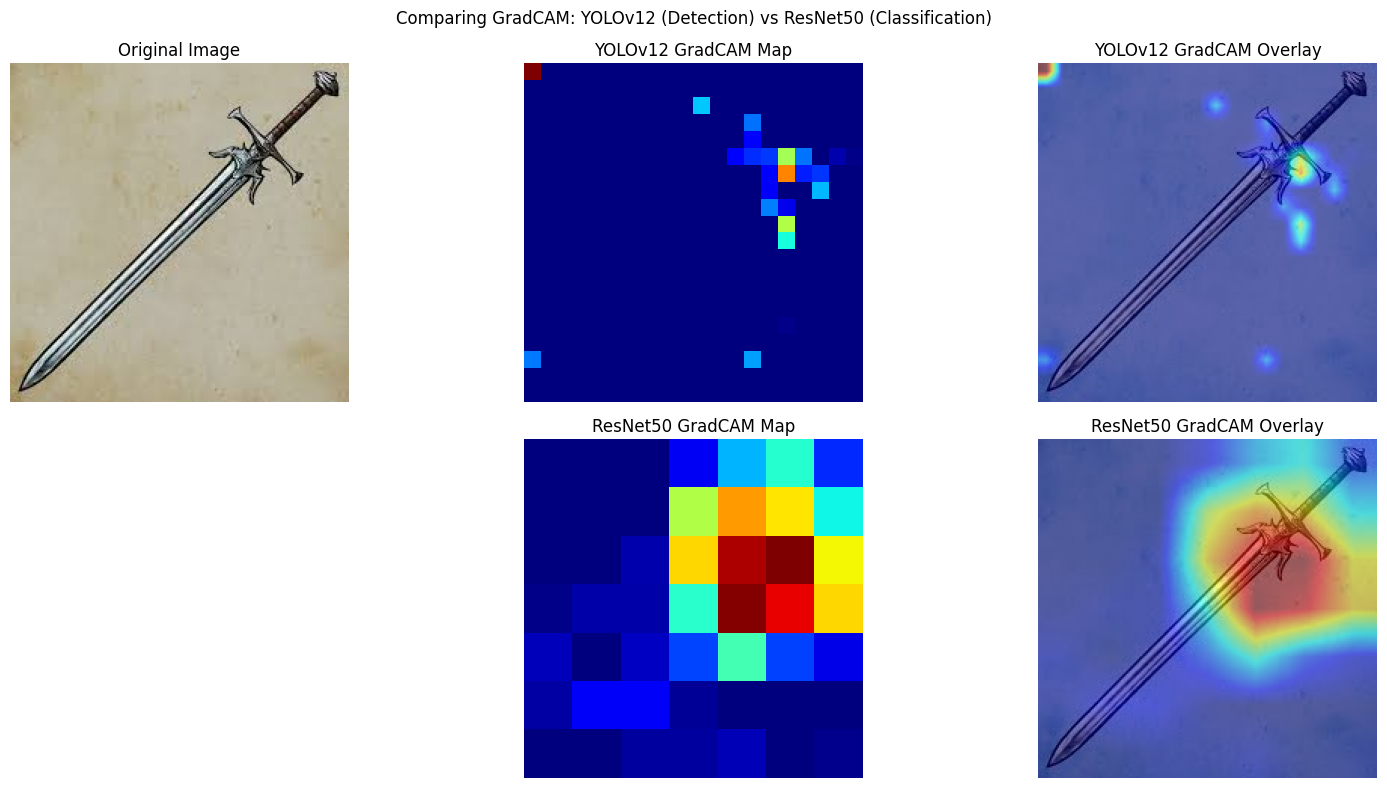


GradCAM visualization complete!
ResNet50 predicted class: 7 (Sniper)
YOLOv12 top detection: Class 1 (Bazooka)
Confidence: -0.8650
Bounding box: [-0.5989742  0.8230692 -2.0525875 -0.810585 ]


In [22]:
# Main script for running GradCAM analysis in Google Colab

# First, let's make sure we have all required dependencies
!pip install opencv-python matplotlib pillow -q

# Import necessary libraries
import torch
import torch.nn as nn
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import sys
import os

# Import the GradCAM implementation
from gradcam_implementation import ResNetGradCAM, YOLOGradCAM, compare_gradcam_models

# Load the trained models
def load_yolov12_model(model_path):
    """
    Load trained YOLOv12 model
    """
    try:
        # Try to import YOLOv12 from your implementation
        print("Attempting to import YOLOv12...")

        # Get the model, first check if ultralytics is installed
        try:
            import ultralytics
            from ultralytics import YOLO
            print("Using ultralytics YOLO")

            # Load YOLO model from ultralytics
            model = YOLO(model_path)
            return model.model

        except ImportError:
            print("Ultralytics not found, trying custom YOLOv12 implementation...")

            # Try custom implementation if available
            try:
                # Update this import path according to your setup
                from yolov12.models.yolo import Model
                from yolov12.utils.configs import get_config

                # Load YOLOv12 configuration
                cfg = get_config('/content/drive/MyDrive/YOLOv12/data.yaml')

                # Initialize model
                model = Model(cfg)

                # Load weights
                model.load_state_dict(torch.load(model_path, map_location='cpu'))

                print(f"Custom YOLOv12 model loaded from {model_path}")
                return model

            except ImportError:
                raise ImportError("Could not import YOLOv12 implementation")

    except ImportError:
        print("Could not import YOLOv12. Make sure the module is available.")
        # Fallback to a mock model for demonstration
        print("Using a ResNet50 as a placeholder for demonstration")
        model = torchvision.models.resnet50(pretrained=True)
        if os.path.exists(model_path):
            try:
                model.load_state_dict(torch.load(model_path, map_location='cpu'))
            except:
                print(f"Could not load weights from {model_path}, using pretrained weights")
        return model


def load_resnet50_model(model_path, num_classes):
    """
    Load trained ResNet50 model
    """
    # Initialize ResNet50 with the right number of classes
    model = torchvision.models.resnet50(pretrained=True)

    # Modify the final fully connected layer to match your number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # Load weights if the file exists
    if os.path.exists(model_path):
        try:
            # Try to load the model weights
            model.load_state_dict(torch.load(model_path, map_location='cpu'))
            print(f"ResNet50 model loaded from {model_path}")
        except Exception as e:
            print(f"Error loading ResNet50 weights: {e}")
            print("Using pretrained model with modified final layer")
    else:
        print(f"Model file {model_path} not found. Using pretrained model with modified final layer")

    return model


def get_target_layers(yolo_model, resnet_model):
    """
    Get target layers for GradCAM

    Typically for ResNet50, we use the last convolutional layer.
    For YOLOv12, we need to find an appropriate feature extraction layer.
    """
    # For ResNet50, the last layer of the 4th block is a common choice
    resnet_target_layer = resnet_model.layer4[-1]

    # For YOLOv12, this depends on your model architecture
    # Try to find a suitable layer in YOLOv12
    yolo_target_layer = None

    # Check if it's an ultralytics YOLO model
    if hasattr(yolo_model, 'model') and hasattr(yolo_model.model, 'model'):
        # Ultralytics YOLO model structure
        try:
            # Try to get the detection head
            yolo_target_layer = yolo_model.model.model[-1]
            print("Using ultralytics YOLO detection head as target layer")
        except:
            # If that fails, try to find a backbone layer
            print("Searching for suitable backbone layer in ultralytics YOLO")
            for i in range(len(yolo_model.model.model) - 1, -1, -1):
                if isinstance(yolo_model.model.model[i], nn.Conv2d):
                    yolo_target_layer = yolo_model.model.model[i]
                    print(f"Found Conv2d layer at index {i}")
                    break

    # Check for custom YOLOv12 structures
    if yolo_target_layer is None:
        if hasattr(yolo_model, 'model') and hasattr(yolo_model.model, 'backbone'):
            # If your YOLO model has a structure like this
            yolo_target_layer = yolo_model.model.backbone[-1]
            print("Using model.backbone[-1] as target layer")
        elif hasattr(yolo_model, 'backbone'):
            # Or if it has a direct backbone
            yolo_target_layer = yolo_model.backbone[-1]
            print("Using backbone[-1] as target layer")

    # If still not found, fall back to heuristic search
    if yolo_target_layer is None:
        # Fallback option: try to find any convolutional layer with a large number of filters
        print("Performing heuristic search for suitable target layer")
        max_filters = 0

        for name, module in yolo_model.named_modules():
            if isinstance(module, nn.Conv2d) and module.out_channels > max_filters:
                max_filters = module.out_channels
                yolo_target_layer = module
                print(f"Found Conv2d layer with {max_filters} filters: {name}")

        if yolo_target_layer is None:
            # Last resort - just grab the last convolutional layer
            for name, module in yolo_model.named_modules():
                if isinstance(module, nn.Conv2d):
                    yolo_target_layer = module
                    print(f"Using last found Conv2d layer: {name}")

    print("\nTarget layers identified:")
    print(f"ResNet50: {resnet_target_layer}")
    print(f"YOLOv12: {yolo_target_layer}")

    return yolo_target_layer, resnet_target_layer


def main():
    # Class names from your data.yaml
    class_names = [
        'Automatic Rifle', 'Bazooka', 'Grenade Launcher', 'Handgun', 'Knife',
        'Shotgun', 'SMG', 'Sniper', 'Sword'
    ]

    # Paths to your saved models - update these with your actual paths
    yolo_model_path = '/content/drive/MyDrive/YOLOv12/train_results/weights/best.pt'
    resnet_model_path = '/content/drive/MyDrive/weapon_detection_results/models/finetuned_model.h5'

    # Check if the files exist and provide feedback
    print(f"YOLO model path exists: {os.path.exists(yolo_model_path)}")
    print(f"ResNet model path exists: {os.path.exists(resnet_model_path)}")

    # Ask user to update paths if needed
    print("\nIf the model paths are incorrect, please update them in the code.")
    yolo_path_input = input("Enter the correct YOLO model path (or press Enter to use the default): ")
    if yolo_path_input.strip():
        yolo_model_path = yolo_path_input

    resnet_path_input = input("Enter the correct ResNet model path (or press Enter to use the default): ")
    if resnet_path_input.strip():
        resnet_model_path = resnet_path_input

    # Number of classes from your dataset
    num_classes = 9  # From your data.yaml

    # Load models
    print("\nLoading YOLO model...")
    yolo_model = load_yolov12_model(yolo_model_path)

    print("\nLoading ResNet50 model...")
    resnet_model = load_resnet50_model(resnet_model_path, num_classes)

    # Get target layers for GradCAM
    print("\nIdentifying target layers for GradCAM...")
    yolo_target_layer, resnet_target_layer = get_target_layers(yolo_model, resnet_model)

    # Set models to evaluation mode
    yolo_model.eval()
    resnet_model.eval()

    # Example image path - ask user for input
    print("\nNow we need a test image to apply GradCAM visualization.")
    image_path = input("Enter path to your test image: ")

    if not os.path.exists(image_path):
        print(f"Image path {image_path} not found. Using a placeholder image...")
        # Create a simple placeholder image
        import numpy as np
        from PIL import Image
        placeholder = np.zeros((416, 416, 3), dtype=np.uint8)
        # Add some shapes to make it interesting
        placeholder[100:300, 100:300, 0] = 255  # Red square
        placeholder[150:250, 200:350, 1] = 255  # Green rectangle
        im = Image.fromarray(placeholder)
        image_path = '/content/Weapon-Detection-V3/Weapon/Weapon Project/weapon_detection/test/test/weapon1.jpg'
        im.save(image_path)

    print(f"\nApplying GradCAM to image: {image_path}")

    # Apply GradCAM to both models and compare
    try:
        results = compare_gradcam_models(
            image_path,
            yolo_model,
            resnet_model,
            yolo_target_layer,
            resnet_target_layer
        )

        print("\nGradCAM visualization complete!")

        # Display ResNet50 prediction with class name
        class_idx = results['resnet']['class']
        print(f"ResNet50 predicted class: {class_idx} ({class_names[class_idx] if class_idx < len(class_names) else 'Unknown'})")

        # YOLOv12 detections are more complex, but you can print the top detection
        if len(results['yolo']['detections']) > 0:
            top_detection = results['yolo']['detections'][0]
            class_id = int(top_detection[5])
            print(f"YOLOv12 top detection: Class {class_id} ({class_names[class_id] if class_id < len(class_names) else 'Unknown'})")
            print(f"Confidence: {top_detection[4]:.4f}")
            print(f"Bounding box: {top_detection[:4]}")
        else:
            print("No detections from YOLO model")

    except Exception as e:
        print(f"Error during GradCAM processing: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()

In [28]:
# Weapon Detection ResNet50 Inference Code
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import glob
from PIL import Image
import time

# Configuration
IMG_SIZE = 224  # ResNet50 default input size
MODEL_PATH = '/content/drive/MyDrive/weapon_detection_results/models/final_fine_tuned_model.h5'  # Change to your model path
TEST_IMAGES_PATH = '/content/Weapon-Detection-V3/Weapon/Weapon Project/weapon_detection/test/test'  # Change to your test images folder
RESULTS_PATH = 'inference_results'  # Where to save inference results

# Create results directory
os.makedirs(RESULTS_PATH, exist_ok=True)

def load_and_preprocess_image(img_path):
    """Load and preprocess a single image"""
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # ResNet50 preprocessing
    return img, img_array

def predict_image(model, img_path, class_names):
    """Make prediction on single image and return results"""
    start_time = time.time()

    # Load and preprocess image
    original_img, processed_img = load_and_preprocess_image(img_path)

    # Make prediction
    predictions = model.predict(processed_img)
    top_pred_idx = np.argmax(predictions[0])
    top_pred_score = float(predictions[0][top_pred_idx])
    predicted_class = class_names[top_pred_idx]

    # Calculate inference time
    inference_time = time.time() - start_time

    return {
        'image_path': img_path,
        'predicted_class': predicted_class,
        'confidence': top_pred_score,
        'predictions': predictions[0],
        'inference_time': inference_time,
        'original_img': original_img
    }

def visualize_prediction(result, class_names, save_path=None):
    """Visualize prediction results"""
    img = result['original_img']
    predictions = result['predictions']

    # Create figure
    plt.figure(figsize=(12, 6))

    # Plot image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Prediction: {result['predicted_class']}\nConfidence: {result['confidence']:.2%}")
    plt.axis('off')

    # Plot probability distribution
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(class_names))
    plt.barh(y_pos, predictions)
    plt.yticks(y_pos, class_names)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')
    plt.tight_layout()

    # Save or show
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def batch_predict(model, images_path, class_names, batch_size=16):
    """Process multiple images in batch for efficiency"""
    # Get all image files
    image_files = []
    for ext in ['jpg', 'jpeg', 'png']:
        image_files.extend(glob.glob(os.path.join(images_path, f'*.{ext}')))
        image_files.extend(glob.glob(os.path.join(images_path, f'*.{ext.upper()}')))

    if not image_files:
        print(f"No images found in {images_path}")
        return []

    print(f"Found {len(image_files)} images to process")

    results = []
    for i, img_path in enumerate(image_files):
        try:
            print(f"Processing image {i+1}/{len(image_files)}: {os.path.basename(img_path)}")
            result = predict_image(model, img_path, class_names)

            # Save visualization
            save_path = os.path.join(RESULTS_PATH, f"{os.path.splitext(os.path.basename(img_path))[0]}_result.png")
            visualize_prediction(result, class_names, save_path)

            results.append(result)

        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

    return results

def generate_report(results, output_path):
    """Generate a summary report of predictions"""
    report_path = os.path.join(output_path, 'inference_report.txt')

    with open(report_path, 'w') as f:
        f.write("======= Weapon Detection Inference Report =======\n\n")
        f.write(f"Total images processed: {len(results)}\n")
        f.write("\nDetailed Results:\n")

        for i, result in enumerate(results):
            f.write(f"\n--- Image {i+1}: {os.path.basename(result['image_path'])} ---\n")
            f.write(f"Predicted class: {result['predicted_class']}\n")
            f.write(f"Confidence: {result['confidence']:.2%}\n")
            f.write(f"Inference time: {result['inference_time']:.4f} seconds\n")

    print(f"Report generated at {report_path}")

def main():
    try:
        # Check if model path exists
        if not os.path.exists(MODEL_PATH):
            print(f"Error: Model file not found at {MODEL_PATH}")
            return

        # Load model
        print("Loading trained model...")
        model = load_model(MODEL_PATH)
        print("Model loaded successfully!")

        # Define class names - update these to match your trained classes
        # You can either hardcode these based on your training data or load them from a file
        class_names = [
            "Automatic Rifle",
            "Bazooka",
            "Grenade Launcher",
            "Handgun",
            "Knife",
            "Shotgun",
            "SMG",
            "Sniper",
            "Sword"
        ]  # Replace with your actual class names

        # Process all test images
        results = batch_predict(model, TEST_IMAGES_PATH, class_names)

        if results:
            # Generate summary report
            generate_report(results, RESULTS_PATH)

            # Print sample results
            print("\nSample predictions:")
            for i, result in enumerate(results[:5]):  # Show first 5 results
                print(f"Image: {os.path.basename(result['image_path'])}")
                print(f"Prediction: {result['predicted_class']} with {result['confidence']:.2%} confidence")
                print(f"Inference time: {result['inference_time']:.4f} seconds\n")

            print(f"All results saved to {RESULTS_PATH}")

    except Exception as e:
        print("An error occurred:", str(e))
        import traceback
        traceback.print_exc()

# Function to perform inference on a single image (useful for external calls)
def predict_single_image(image_path, model_path=MODEL_PATH):
    """Utility function to predict a single image from external code"""
    # Load model
    model = load_model(model_path)

    # Define class names - update these to match your trained classes
    class_names = [
        "Automatic Rifle",
        "Bazooka",
        "Grenade Launcher",
        "Handgun",
        "Knife",
        "Shotgun",
        "SMG",
        "Sniper",
        "Sword"
    ]  # Replace with your actual class names

    # Process image
    result = predict_image(model, image_path, class_names)

    return {
        'image_path': image_path,
        'predicted_class': result['predicted_class'],
        'confidence': result['confidence'],
        'class_probabilities': dict(zip(class_names, result['predictions'].tolist()))
    }

# Entry point
if __name__ == '__main__':
    main()

Loading trained model...


Model loaded successfully!
Found 8 images to process
Processing image 1/8: weapons.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Processing image 2/8: weapons2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Processing image 3/8: weapon3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Processing image 4/8: army.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Processing image 5/8: weapon2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Processing image 6/8: terrorists.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Processing image 7/8: terrorists2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Processing image 8/8: weapon1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Report generated at inference_results/inference_report.txt

Sample predictions:
Image: weapons.jpg
Prediction: SMG with 100.00% confidence
Inference time: 5.2096 seconds

Image: weapons2.jpg
Prediction: SMG with 100.00% confidence
Inference time: 0.3795 seconds

Image: weapon3.jpg
Prediction: SMG with 100.00% confidence
Inference time: 0.3693 seconds

Image: 

Found 8 result images.



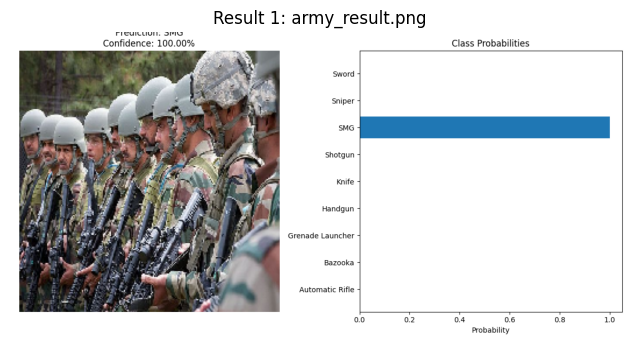

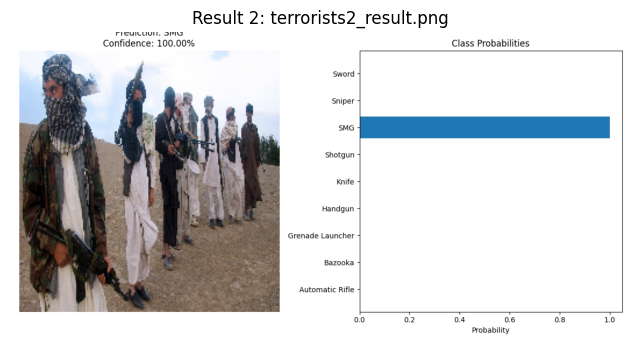

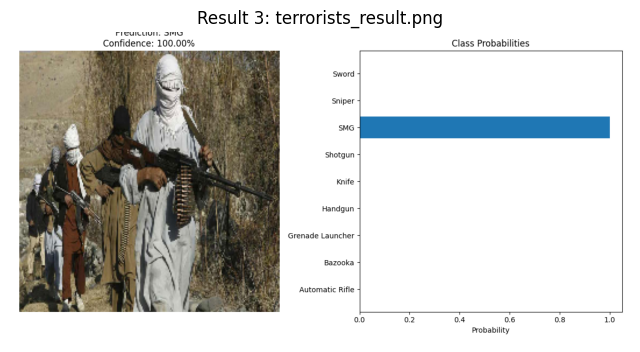

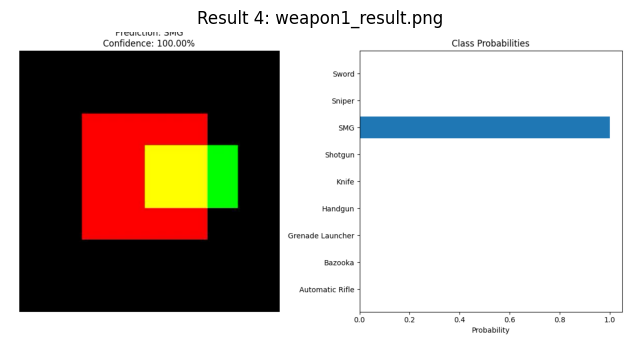

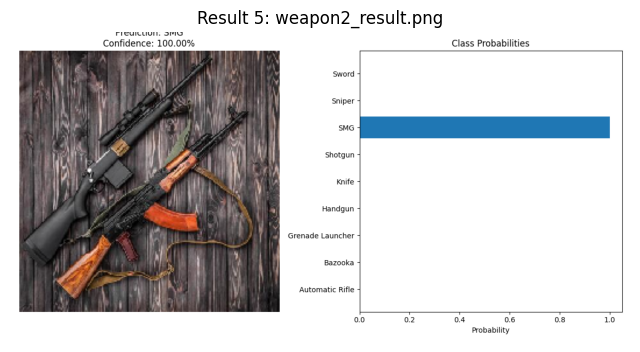

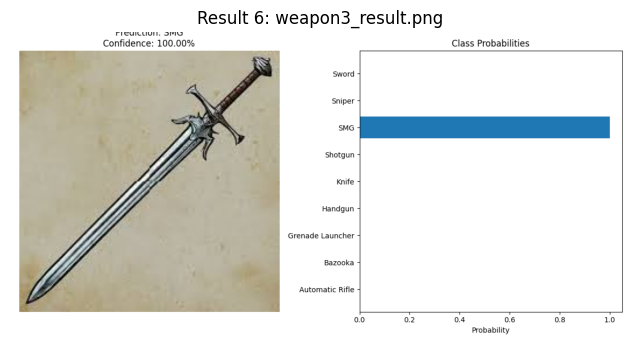

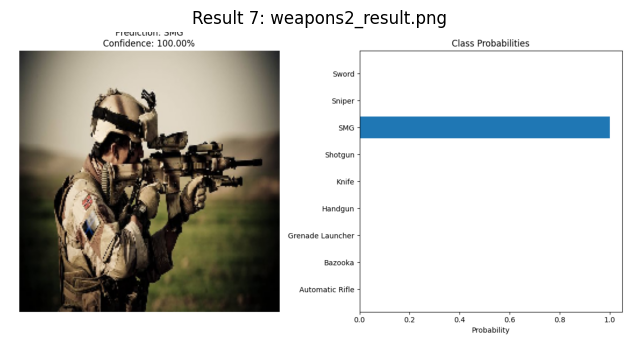

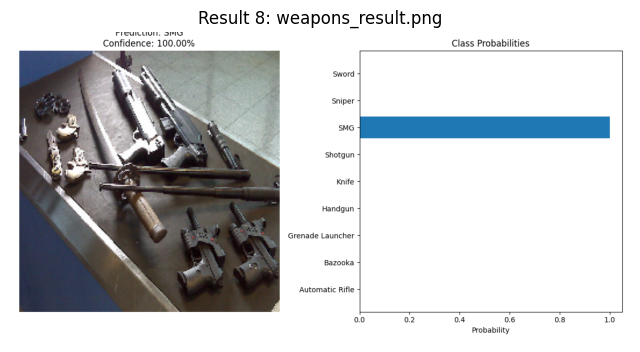

In [26]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path where inference results were saved
RESULTS_PATH = 'inference_results'  # or the path you used

def show_all_results(results_path):
    """Display all saved result images from inference."""
    result_files = sorted([
        os.path.join(results_path, fname)
        for fname in os.listdir(results_path)
        if fname.endswith('_result.png')
    ])

    if not result_files:
        print(f"No result images found in {results_path}")
        return

    print(f"Found {len(result_files)} result images.\n")

    for i, file in enumerate(result_files, 1):
        try:
            img = Image.open(file)
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.title(f"Result {i}: {os.path.basename(file)}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error displaying {file}: {str(e)}")

# Run the function
show_all_results(RESULTS_PATH)